## Mount and Import


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-byi3n_cx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-byi3n_cx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 93.3 MB/s eta 0:00:00


In [ ]:
import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import re
import fitz  # PyMuPDF is imported as fitz
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tqdm import tqdm
from pathlib import Path
from PIL import Image, ImageFilter
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F_nn  # Rename this to avoid conflict
from torchvision.transforms import functional as F  # This keeps F.hflip valid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing and data augmentation

In [ ]:
import shutil
from pathlib import Path

# Define the source (Google Drive) and destination (local runtime) directories.
src_dir = Path("/content/drive/MyDrive/raw_Dataset_2")
dest_dir = Path("./raw_dataset")

# List all files from the source directory.
src_files = sorted([p for p in src_dir.rglob('*') if p.is_file()])

# Check if the destination exists and, if so, list all files from it.
if dest_dir.exists():
    dest_files = sorted([p for p in dest_dir.rglob('*') if p.is_file()])
else:
    dest_files = []

print(f"Source file count: {len(src_files)}")
print(f"Destination file count: {len(dest_files)}")

# Copy the dataset if the destination does not exist or file counts mismatch.
if not dest_dir.exists() or len(src_files) != len(dest_files):
    print(f"Copying raw dataset from {src_dir} to {dest_dir} ...")
    # If destination exists but file counts mismatch, remove it.
    if dest_dir.exists():
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)
    print("Copy complete.")
else:
    print("Sanity check passed: All files have been copied successfully. Skipping copy.")

Source file count: 14784
Destination file count: 11115
Copying raw dataset from /content/drive/MyDrive/raw_Dataset_2 to raw_dataset ...
Copy complete.


In [ ]:
def is_uppercase(stem):
    """
    Returns True if the filename stem starts with an uppercase letter,
    which we use to mean it's a cat image.
    """
    if not stem:
        return False
    return stem[0].isupper()

def colorize_label(label_img, include_boundary=False):
    """
    Converts a numeric mask (PIL Image in 'L') into an RGB image.
    For include_boundary==False, the expected classes are:
      0: background -> black
      1: cat       -> orange
      2: dog       -> cyan
    For include_boundary==True, we expect an additional class:
      3: boundary  -> white
    """
    arr = np.array(label_img)
    color_arr = np.zeros((arr.shape[0], arr.shape[1], 3), dtype=np.uint8)
    if include_boundary:
        color_map = {
            0: (0,   0,   0),      # background = black
            1: (255, 165, 0),      # cat = orange
            2: (0,   255, 255),    # dog = cyan
            3: (255, 255, 255)     # boundary = white
        }
    else:
        color_map = {
            0: (0, 0, 0),
            1: (255, 165, 0),
            2: (0, 255, 255)
        }
    for class_val, color in color_map.items():
        color_arr[arr == class_val] = color
    return Image.fromarray(color_arr, mode="RGB")

def convert_label_to_three_classes(label_img, is_cat):
    """
    For TrainVal:
    Convert a grayscale label (mode "L") that may contain:
      - 0 for background,
      - 255 for boundary,
      - values in (1..254) for the animal region,
    into a new label with:
      - 0 for background (and boundary merged),
      - 1 for cat (if is_cat True),
      - 2 for dog (if is_cat False).
    """
    arr = np.array(label_img, dtype=np.uint8)
    new_label = np.zeros_like(arr, dtype=np.uint8)
    if is_cat:
        new_label[(arr > 0) & (arr < 255)] = 1
    else:
        new_label[(arr > 0) & (arr < 255)] = 2
    return Image.fromarray(new_label)

def convert_label_test(label_img, is_cat):
    """
    For Test:
    Convert an RGB label image (that contains a boundary) into a numeric mask with 4 classes:
      0 = background (black)
      3 = boundary (white; pixels where R=G=B=255)
      For the remaining animal region, assign:
          1 if is_cat is True (cat),
          2 if is_cat is False (dog).
    """
    arr = np.array(label_img)
    # Create a single-channel mask
    mask = np.zeros(arr.shape[:2], dtype=np.uint8)
    # Background: where pixel is black
    background = (arr[:,:,0] == 0) & (arr[:,:,1] == 0) & (arr[:,:,2] == 0)
    mask[background] = 0
    # Boundary: where pixel is white
    boundary = (arr[:,:,0] == 255) & (arr[:,:,1] == 255) & (arr[:,:,2] == 255)
    mask[boundary] = 3
    # Animal region: everything that is not background or boundary
    animal = ~(background | boundary)
    if is_cat:
        mask[animal] = 1
    else:
        mask[animal] = 2
    return Image.fromarray(mask)

# --------------------------
# Resizing and Padding Classes
# --------------------------

class ResizeWithPadding:
    """For color images. Uses bilinear interpolation."""
    def __init__(self, target_size=512, padding_mode='mean', force_resize=True, resize_dims=(128, 128)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims
        assert padding_mode in ['mean', 'reflect', 'hybrid'], "Padding mode must be 'mean', 'reflect', or 'hybrid'"
        self.padding_mode = padding_mode

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        if self.padding_mode == 'mean':
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        elif self.padding_mode == 'reflect':
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
        else:
            reflected = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(reflected, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        return padded_image

    def __call__(self, img):
        arr = np.array(img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

class ResizeWithPaddingLabel:
    """For label images. Uses nearest-neighbor interpolation."""
    def __init__(self, target_size=512, force_resize=False, resize_dims=(256, 256)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w*scale), int(h*scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    def __call__(self, label_img):
        arr = np.array(label_img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

# --------------------------
# Augmentation Function for Synchronized Transforms
# --------------------------

def elastic_transform_pair(image, label, alpha=34, sigma=4):
    """Apply elastic transformation to both image and label."""
    np_img = np.array(image)
    np_label = np.array(label)
    random_state = np.random.RandomState(None)
    shape = np_img.shape[:2]
    dx = (random_state.rand(*shape) * 2 - 1)
    dy = (random_state.rand(*shape) * 2 - 1)
    dx = cv2.GaussianBlur(dx, (17,17), sigma) * alpha
    dy = cv2.GaussianBlur(dy, (17,17), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x+dx).astype(np.float32)
    map_y = (y+dy).astype(np.float32)
    transformed_img = cv2.remap(np_img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    transformed_label = cv2.remap(np_label, map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return Image.fromarray(transformed_img), Image.fromarray(transformed_label)

def augment_pair(image, label, size=(256,256), apply_color=True, **params):
    """
    Applies a random subset of augmentations in random order.
    """
    augmentations = []
    augmentations.append((lambda img, lbl: (F.hflip(img), F.hflip(lbl)), params.get("flip_prob",0.5)))
    def rotate_aug(img, lbl):
        angle = random.uniform(-params.get("rotation_angle",5), params.get("rotation_angle",45))
        return F.rotate(img, angle, interpolation=Image.BILINEAR), F.rotate(lbl, angle, interpolation=Image.NEAREST)
    augmentations.append((rotate_aug, params.get("rotation_prob",0.25)))
    def translate_aug(img, lbl):
        max_translate = params.get("translate_factor", 0.05)*size[0]
        tx = int(random.uniform(-max_translate, max_translate))
        ty = int(random.uniform(-max_translate, max_translate))
        return (F.affine(img, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.BILINEAR),
                F.affine(lbl, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.NEAREST))
    augmentations.append((translate_aug, params.get("translate_prob",0.05)))
    def crop_aug(img, lbl):
        i,j,h,w = transforms.RandomResizedCrop.get_params(img, scale=params.get("crop_scale_range",(0.9,1.0)), ratio=params.get("crop_ratio_range",(1.0,1.0)))
        return (F.resized_crop(img, i,j,h,w,size, interpolation=Image.BILINEAR),
                F.resized_crop(lbl, i,j,h,w,size, interpolation=Image.NEAREST))
    augmentations.append((crop_aug, params.get("crop_prob",0.01)))
    def elastic_aug(img, lbl):
        return elastic_transform_pair(img, lbl, alpha=params.get("elastic_alpha",15), sigma=params.get("elastic_sigma",2))
    augmentations.append((elastic_aug, params.get("elastic_prob",0.01)))
    def scaling_aug(img, lbl):
        scale_factor = random.uniform(*params.get("scaling_range",(0.0,0.0)))
        new_size = (int(size[0]*scale_factor), int(size[1]*scale_factor))
        return (F.resize(img, new_size, interpolation=Image.BILINEAR),
                F.resize(lbl, new_size, interpolation=Image.NEAREST))
    augmentations.append((scaling_aug, params.get("scaling_prob",0.0)))
    def color_aug(img, lbl):
        if random.random() < params.get("blur_prob",0.0):
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(*params.get("blur_radius_range",(0.5,1.5)))))
        color_jitter = transforms.ColorJitter(**params.get("color_jitter_params",{'brightness':0.2,'contrast':0.2,'saturation':0.2,'hue':0.1}))
        img = color_jitter(img)
        return img, lbl
    augmentations.append((color_aug, params.get("color_prob",0.25)))
    random.shuffle(augmentations)
    for func, prob in augmentations:
        if random.random() < prob:
            image, label = func(image, label)
    image = F.center_crop(image, size)
    label = F.center_crop(label, size)
    return image, label

# --------------------------
# OOP Preprocessor Class
# --------------------------

class Preprocessor:
    def __init__(self, raw_color_path, raw_label_path,
                 proc_color_path, proc_label_path,
                 resize_dim=128, do_augmentation=True,
                 is_train=True, max_images=None, aug_count=10, aug_params=None):
        self.aug_params = aug_params if aug_params is not None else {}
        self.raw_color_path = Path(raw_color_path)
        self.raw_label_path = Path(raw_label_path)
        self.proc_color_path = Path(proc_color_path)
        self.proc_label_path = Path(proc_label_path)
        self.resize_dim = resize_dim
        self.do_augmentation = do_augmentation and is_train
        self.is_train = is_train  # True for TrainVal, False for Test
        self.max_images = max_images
        self.aug_count = aug_count
        self.proc_color_path.mkdir(parents=True, exist_ok=True)
        self.proc_label_path.mkdir(parents=True, exist_ok=True)
        self.transform_img = ResizeWithPadding(target_size=224, padding_mode='mean',
                                              force_resize=True, resize_dims=(resize_dim, resize_dim))
        self.transform_label = ResizeWithPaddingLabel(target_size=224, force_resize=True,
                                                      resize_dims=(resize_dim, resize_dim))

    def process(self):
        image_extensions = (".jpg", ".jpeg", ".png")
        image_files = [f for f in self.raw_color_path.rglob("*") if f.suffix.lower() in image_extensions]
        if self.max_images is not None:
            image_files = image_files[:self.max_images]
        if not image_files:
            print("❌ No images found in", self.raw_color_path)
            return
        for img_file in image_files:
            label_file = self.raw_label_path / f"{img_file.stem}.png"
            if not label_file.exists():
                print(f"⚠️  Label for {img_file.name} not found, skipping.")
                continue

            # For TrainVal, load label in grayscale; for Test, load in RGB (to preserve boundaries)
            if self.is_train:
                label = Image.open(label_file).convert("L")
            else:
                label = Image.open(label_file).convert("RGB")
            img = Image.open(img_file).convert("RGB")
            proc_img = self.transform_img(img)
            proc_label = self.transform_label(label)
            cat_or_dog = is_uppercase(img_file.stem)  # True => cat, False => dog

            if self.is_train:
                # Merge boundary with background and set animal region accordingly.
                numeric_label = convert_label_to_three_classes(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label)
            else:
                # Test: Convert RGB label to numeric with boundary preserved (0,1,2,3),
                # then colorize using the same mapping (cat always orange, dog always cyan, boundary white).
                numeric_label = convert_label_test(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label, include_boundary=True)

            if cat_or_dog:
                proc_img.save(self.proc_color_path / f"cat_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"cat_{label_file.name}")
                print(f"Processed (cat) {img_file.name}")
            else:
                proc_img.save(self.proc_color_path / f"dog_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"dog_{label_file.name}")
                print(f"Processed (dog) {img_file.name}")

            if self.is_train and self.do_augmentation:
                for i in range(self.aug_count):
                    aug_img, aug_label = augment_pair(proc_img, numeric_label,
                                                      size=(self.resize_dim, self.resize_dim),
                                                      **self.aug_params)
                    colorized_aug_label = colorize_label(aug_label)
                    if cat_or_dog:
                        aug_img.save(self.proc_color_path / f"cat_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"cat_{label_file.stem}_aug_{i}{label_file.suffix}")
                    else:
                        aug_img.save(self.proc_color_path / f"dog_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"dog_{label_file.stem}_aug_{i}{label_file.suffix}")
                    print(f"Augmented {img_file.name} -> aug {i}")

# --------------------------
# Command Line Interface
# --------------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Preprocess train/test images with labels/masks using relative paths."
    )
    parser.add_argument("--raw_color", type=str, required=True, default='raw/TrainVal/color')
    parser.add_argument("--raw_label", type=str, required=True, default='raw/TrainVal/label')
    parser.add_argument("--proc_color", type=str, required=True, default='Dataset/processed/TrainVal/color')
    parser.add_argument("--proc_label", type=str, required=True, default='Dataset/processed/TrainVal/label')
    parser.add_argument("--resize_dim", type=int, default=128)
    parser.add_argument("--no_augment", action="store_true")
    parser.add_argument("--max_images", type=int, default=None)
    parser.add_argument("--aug_count", type=int, default=10)
    parser.add_argument("--set_type", type=str, choices=["TrainVal", "Test"], default="TrainVal")
    parser.add_argument("--flip_prob", type=float, default=0.5)
    parser.add_argument("--rotation_angle", type=float, default=5)
    parser.add_argument("--translate_factor", type=float, default=0.05)
    parser.add_argument("--crop_scale_min", type=float, default=0.9)
    parser.add_argument("--crop_scale_max", type=float, default=1.0)
    parser.add_argument("--crop_ratio_min", type=float, default=1.0)
    parser.add_argument("--crop_ratio_max", type=float, default=1.0)
    parser.add_argument("--elastic_alpha", type=float, default=15)
    parser.add_argument("--elastic_sigma", type=float, default=2)
    parser.add_argument("--scaling_min", type=float, default=0.0)
    parser.add_argument("--scaling_max", type=float, default=0.0)
    parser.add_argument("--blur_prob", type=float, default=0.3)
    parser.add_argument("--blur_radius_min", type=float, default=0.5)
    parser.add_argument("--blur_radius_max", type=float, default=1.5)
    parser.add_argument("--color_jitter_brightness", type=float, default=0.2)
    parser.add_argument("--color_jitter_contrast", type=float, default=0.2)
    parser.add_argument("--color_jitter_saturation", type=float, default=0.2)
    parser.add_argument("--color_jitter_hue", type=float, default=0.1)

    # Example invocation (change as needed)
    sys.argv = [
        'preprocessing.py',
        '--raw_color', './Datasetraw/Test/color',
        '--raw_label', './Dataset/raw/Test/label',
        '--proc_color', './Dataset/processed/Test/color',
        '--proc_label', './Dataset/processed/Test/label',
        '--resize_dim', '128',
        '--no_augment',
        '--set_type', 'Test'
    ]

    '''sys.argv = ['preprocessing.py',
                '--raw_color', './Dataset/raw/TrainVal/color',
                '--raw_label', './Dataset/raw/TrainVal/label',
                '--proc_color', './Dataset/processed/TrainVal/color',
                '--proc_label', './Dataset/processed/TrainVal/label',
                '--resize_dim', '128',
                '--aug_count', '10',
                '--set_type', 'TrainVal',
                '--translate_factor', '0.02',
                '--elastic_alpha', '0.0',
                '--elastic_sigma', '0.05',
                '--blur_radius_min', '0.0',
                '--blur_radius_max', '0.05']'''

    args = parser.parse_args()

    if args.set_type == "TrainVal":
        raw_color = Path("./raw_dataset/TrainVal/color")
        raw_label = Path("./raw_dataset/TrainVal/label")
        proc_color = Path("./Dataset/processed/TrainVal/color")
        proc_label = Path("./Dataset/processed/TrainVal/label")
        is_train = True
    else:
        raw_color = Path("./raw_dataset/Test/color")
        raw_label = Path("./raw_dataset/Test/label")
        proc_color = Path("./Dataset/processed/Test/color")
        proc_label = Path("./Dataset/processed/Test/label")
        is_train = False

    aug_params = {
        "flip_prob": args.flip_prob,
        "rotation_angle": args.rotation_angle,
        "rotation_prob": 0.25,
        "translate_factor": args.translate_factor,
        "translate_prob": 0.05,
        "crop_scale_range": (args.crop_scale_min, args.crop_scale_max),
        "crop_ratio_range": (args.crop_ratio_min, args.crop_ratio_max),
        "crop_prob": 0.01,
        "elastic_alpha": args.elastic_alpha,
        "elastic_sigma": args.elastic_sigma,
        "elastic_prob": 0.01,
        "scaling_range": (0.8, 1.2),
        "scaling_prob": 0.05,
        "blur_prob": args.blur_prob,
        "blur_radius_range": (args.blur_radius_min, args.blur_radius_max),
        "color_jitter_params": {
            "brightness": args.color_jitter_brightness,
            "contrast": args.color_jitter_contrast,
            "saturation": args.color_jitter_saturation,
            "hue": args.color_jitter_hue,
        },
        "color_prob": 1.0
    }

    preprocessor = Preprocessor(
        raw_color, raw_label,
        proc_color, proc_label,
        resize_dim=args.resize_dim,
        do_augmentation=not args.no_augment,
        is_train=is_train,
        max_images=args.max_images,
        aug_count=args.aug_count,
        aug_params=aug_params
    )

    preprocessor.process()

❌ No images found in raw_dataset/Test/color


In [ ]:
# Compress the local folder 'Dataset' into an archive.
!tar -czf /tmp/dataset.tar.gz -C ./ Dataset

# Copy the archive to your Google Drive.
!cp /tmp/dataset.tar.gz /content/drive/MyDrive/

# Change to the Drive directory.
%cd /content/drive/MyDrive/

# Extract the archive while renaming 'Dataset' to 'Dataset_P'.
# The --transform option changes the folder name during extraction.
!tar --transform='s/^Dataset/Dataset_P/' -xzf dataset.tar.gz

## Sanity Check


In [ ]:
# import shutil
# from pathlib import Path

# # --- Step 1: Compress the local folder "Dataset" (located at /content/Dataset) into an archive.
# !tar -czf /tmp/Dataset.tar.gz -C /content Dataset

# # --- Step 2: Copy the archive to Google Drive with the desired new name.
# # This saves the archive on Drive as "Dataset_P.tar.gz".
# !cp /tmp/Dataset.tar.gz /content/drive/MyDrive/Dataset_P.tar.gz

# # --- Step 3: Copy the archive back from Drive to the local runtime.
# !cp /content/drive/MyDrive/Dataset_P.tar.gz /tmp/

# # --- Step 4: Extract the archive to a new local folder.
# # Create a dedicated folder for extraction.
# !mkdir -p /content/Dataset_P_extracted
# !tar -xzf /tmp/Dataset_P.tar.gz -C /content/Dataset_P_extracted

# # The archive contains a folder named "Dataset" so rename it to "Dataset_P".
# !mv /content/Dataset_P_extracted/Dataset /content/Dataset_P_extracted/Dataset_P

# # --- Step 5: Sanity check by comparing file counts.
# original_files = sorted([p for p in Path("/content/Dataset").rglob('*') if p.is_file()])
# extracted_files = sorted([p for p in Path("/content/Dataset_P_extracted/Dataset_P").rglob('*') if p.is_file()])

# print(f"Original file count (Dataset): {len(original_files)}")
# print(f"Extracted file count (Dataset_P): {len(extracted_files)}")

# if len(original_files) == len(extracted_files):
#     print("Sanity check passed: File counts match!")
# else:
#     print("Sanity check failed: File counts mismatch!")

Original file count (Dataset): 88380
Extracted file count (Dataset_P): 88380
Sanity check passed: File counts match!


## Load to runtime


In [ ]:
# from pathlib import Path
# import shutil

# # Define the path to the archive on Google Drive.
# archive_path = "/content/drive/MyDrive/Dataset_P.tar.gz"

# # Remove any existing local "Dataset" folder to avoid conflicts.
# dest_folder = Path("/content/Dataset")
# if dest_folder.exists():
#     shutil.rmtree(dest_folder)
#     print("Removed existing /content/Dataset folder.")

# # Extract the archive directly to /content.
# !tar -xzf {archive_path} -C /content

# # After extraction, the folder will be named "Dataset" if that is the name in the archive.
# if dest_folder.exists():
#     print("Extraction successful: 'Dataset' folder is now available in the local runtime.")
# else:
#     print("Extraction failed: 'Dataset' folder was not found.")

Extraction successful: 'Dataset' folder is now available in the local runtime.


In [ ]:
from pathlib import Path
import shutil

# Define the destination folder.
dest_folder = Path("/content/processed_3")

# Remove any existing local folder to avoid conflicts.
if dest_folder.exists():
    shutil.rmtree(dest_folder)
    print("Removed existing /content/processed_3 folder.")

# Use the shell command to unzip the file from Google Drive to /content.
!unzip /content/drive/MyDrive/Sams_processed_data.zip -d /content

# Check if the destination folder exists.
if dest_folder.exists():
    print("Extraction successful: 'Sams_processed_data' folder is now available in the local runtime.")
else:
    print("Extraction completed. Please verify the file structure.")

Streaming output truncated to the last 5000 lines.
  inflating: /content/processed_3/Test/label/cat_Sphynx_46.png  
  inflating: /content/processed_3/Test/label/dog_basset_hound_35.png  
  inflating: /content/processed_3/Test/label/dog_great_pyrenees_95.png  
  inflating: /content/processed_3/Test/label/dog_american_bulldog_39.png  
  inflating: /content/processed_3/Test/label/cat_Bombay_23.png  
  inflating: /content/processed_3/Test/label/dog_english_setter_51.png  
  inflating: /content/processed_3/Test/label/dog_english_setter_92.png  
  inflating: /content/processed_3/Test/label/cat_Ragdoll_262.png  
  inflating: /content/processed_3/Test/label/dog_scottish_terrier_46.png  
  inflating: /content/processed_3/Test/label/dog_great_pyrenees_94.png  
  inflating: /content/processed_3/Test/label/dog_great_pyrenees_57.png  
  inflating: /content/processed_3/Test/label/cat_Ragdoll_90.png  
  inflating: /content/processed_3/Test/label/cat_Ragdoll_84.png  
  inflating: /content/processed_3/

In [ ]:
import os

base_path = '/content/processed_3/TrainVal'
png_count = 0
jpg_count = 0

# Walk through the directory structure
for root, dirs, files in os.walk(base_path):
    for file in files:
        # Convert filename to lowercase for case-insensitive matching
        if file.lower().endswith('.png'):
            png_count += 1
        elif file.lower().endswith('.jpg') or file.lower().endswith('.jpeg'):
            jpg_count += 1

print("Total PNG files:", png_count)
print("Total JPG files:", jpg_count)

Total PNG files: 22323
Total JPG files: 22324


## Installation of CLIP

In [ ]:
import shutil
from pathlib import Path

# Define the source (Google Drive) and destination (local runtime) file paths.
src_file = Path("/content/drive/MyDrive/clip_OPENAI_segmentation_best.pth")
dest_file = Path("./clip_OPENAI_segmentation_best.pth")

# Check if the model weights file exists in the runtime directory.
if not dest_file.exists():
    print(f"Copying model weights from {src_file} to {dest_file} ...")
    shutil.copy2(src_file, dest_file)
    print("Copy complete.")
else:
    print(f"The model weights already exist at {dest_file}; skipping copy.")

# Sanity check: verify that the destination file now exists.
if dest_file.exists():
    print("Sanity check passed: The model weights file exists in the runtime directory.")
else:
    print("Sanity check failed: The model weights file is missing!")

Copying model weights from /content/drive/MyDrive/clip_OPENAI_segmentation_best.pth to clip_OPENAI_segmentation_best.pth ...
Copy complete.
Sanity check passed: The model weights file exists in the runtime directory.


In [ ]:
import shutil
from pathlib import Path

# Define the source (Google Drive) and destination (local runtime) file paths.
src_file = Path("/content/drive/MyDrive/pointer_model_best.pth")
dest_file = Path("./pointer_model_best.pth")

# Check if the model weights file exists in the runtime directory.
if not dest_file.exists():
    print(f"Copying model weights from {src_file} to {dest_file} ...")
    shutil.copy2(src_file, dest_file)
    print("Copy complete.")
else:
    print(f"The model weights already exist at {dest_file}; skipping copy.")

# Sanity check: verify that the destination file now exists.
if dest_file.exists():
    print("Sanity check passed: The model weights file exists in the runtime directory.")
else:
    print("Sanity check failed: The model weights file is missing!")

Copying model weights from /content/drive/MyDrive/pointer_model_best.pth to pointer_model_best.pth ...
Copy complete.
Sanity check passed: The model weights file exists in the runtime directory.


In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zgp3ji6h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zgp3ji6h
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import clip
import torch


## Preprocessing data

In [ ]:
from clip.simple_tokenizer import SimpleTokenizer

tokenizer = SimpleTokenizer()
tokens = tokenizer.encode("Hello world!")
print(tokens)

class SegmentationDatasetWithText(Dataset):
    """
    Dataset for segmentation with text prompts.

    Assumes:
      - Images are in root_dir/color.
      - Masks are in root_dir/label.
      - Each mask is a color-coded image where:
          • Background: Black [0,0,0] → 0
          • Cat: Orange [255,165,0] → 1
          • Dog: Cyan [0,255,255] → 2
      - A text prompt is generated from the filename, e.g.:
            "cat_Siamese_27.png" → "a photo of a Siamese cat"
    """
    def __init__(self, root_dir, transform_img, transform_label=None):
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_label = transform_label

        self.image_dir = os.path.join(root_dir, 'color')
        self.mask_dir = os.path.join(root_dir, 'label')

        self.image_paths = sorted([
            fname for fname in os.listdir(self.image_dir)
            if fname.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_filename = self.image_paths[index]
        image_path = os.path.join(self.image_dir, image_filename)
        # Use the same stem and force a .png extension for the mask.
        mask_path = os.path.join(self.mask_dir, Path(image_filename).stem + ".png")

        # Load and transform the image.
        image = Image.open(image_path).convert("RGB")
        if self.transform_img:
            image = self.transform_img(image)

        # Load the mask as RGB and map colors to class indices.
        mask_img = Image.open(mask_path).convert("RGB")
        mask_np = np.array(mask_img, dtype=np.uint8)
        label_new = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)

        # Map background: black → 0.
        background_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 0) & (mask_np[..., 2] == 0)
        label_new[background_mask] = 0

        # Map cat: orange [255,165,0] → 1.
        cat_mask = (mask_np[..., 0] == 255) & (mask_np[..., 1] == 165) & (mask_np[..., 2] == 0)
        label_new[cat_mask] = 1

        # Map dog: cyan [0,255,255] → 2.
        dog_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 255) & (mask_np[..., 2] == 255)
        label_new[dog_mask] = 2

        mask = torch.from_numpy(label_new).long()
        if self.transform_label:
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
            mask = self.transform_label(mask)
            mask = mask.squeeze(0)

        # Generate text prompt based on filename.
        name, _ = os.path.splitext(image_filename)
        match = re.match(r"^(cat|dog)_([A-Za-z_]+)_(\d+)", name)
        if match:
            animal_type = match.group(1)  # "cat" or "dog"
            breed = match.group(2).replace("_", " ")
            breed = breed.title()
            text_prompt = f"a photo of a {breed} {animal_type}"
        else:
            text_prompt = "a photo of an animal"

        token_ids = clip.tokenize([text_prompt]).squeeze(0)

        # (Optional) Decode the tokens for debugging.
        decoded_text = tokenizer.decode(token_ids.tolist())
        # print(f"Original: {text_prompt} → Tokenized: {decoded_text}")

        return image, mask, token_ids

[3306, 1002, 256]


## Prompt Preprocessing

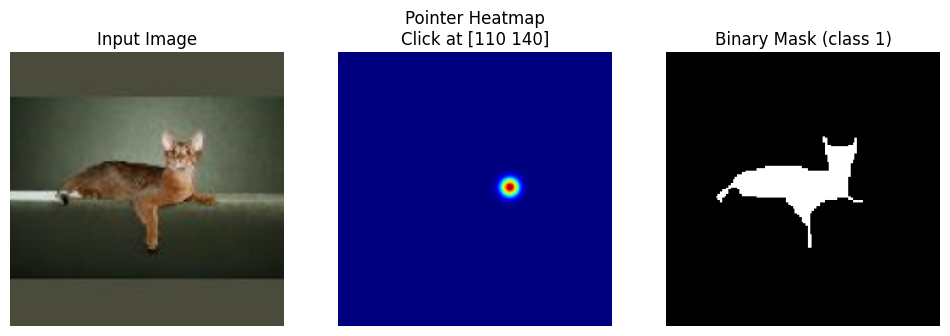

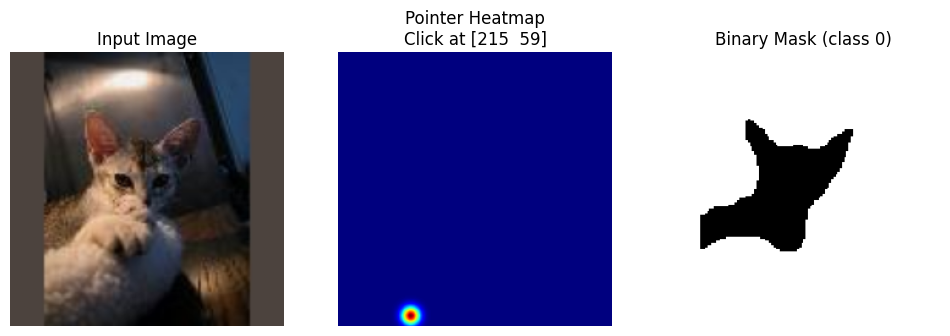

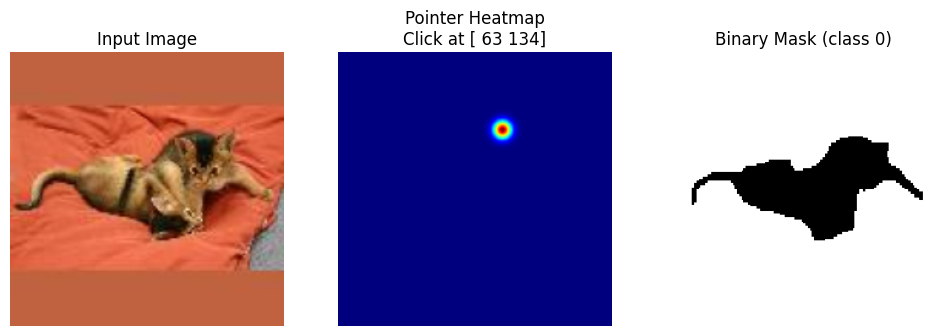

In [ ]:
import os
import re
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt

class PromptSegmentationDataset(Dataset):
    """
    A dataset for prompt-based (point-based) segmentation.

    For each image, a random valid click is sampled from one of the object regions
    (cat, dog, or background) ignoring boundary pixels (which are labeled 255).

    This class returns:
      - image: the transformed image
      - pointer_heatmap: a 1-channel tensor of shape [1, H, W] with a Gaussian centered at the click point
      - binary_mask: a binary ground-truth mask where pixels of the clicked object are 1 and all others are 0,
                     except that boundary pixels remain 255 (to be ignored in loss)
      - chosen_class: the label of the object that was clicked (for debugging)
      - click_coord: the (row, col) coordinate of the sampled click (for verification)
    """
    def __init__(self, root_dir, transform_img, transform_label=None, sigma=5):
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.sigma = sigma

        self.image_dir = os.path.join(root_dir, 'color')
        self.mask_dir = os.path.join(root_dir, 'label')

        # Filter image files to include only those with an existing mask file.
        self.image_paths = sorted([
            fname for fname in os.listdir(self.image_dir)
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')) and
               os.path.exists(os.path.join(self.mask_dir, os.path.splitext(fname)[0] + ".png"))
        ])
        if not self.image_paths:
            raise RuntimeError("No valid image files found with matching masks.")

    def __len__(self):
        return len(self.image_paths)

    def generate_gaussian_heatmap(self, shape, center, sigma):
        """
        Generate a 2D Gaussian heatmap over an image of given shape,
        with the Gaussian centered at 'center' (row, col) and standard deviation sigma.
        The heatmap is normalized so that the maximum value is 1.
        """
        H, W = shape
        y = np.arange(0, H)
        x = np.arange(0, W)
        xx, yy = np.meshgrid(x, y)
        heatmap = np.exp(-((xx - center[1])**2 + (yy - center[0])**2) / (2 * sigma**2))
        heatmap = heatmap / np.max(heatmap)
        return heatmap

    def __getitem__(self, index):
        image_filename = self.image_paths[index]
        image_path = os.path.join(self.image_dir, image_filename)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(image_filename)[0] + ".png")

        # Extra check: if file missing, skip sample.
        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"Warning: Missing file for sample {index}: {image_path} or {mask_path}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Error loading image {image_path}: {e}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))

        try:
            mask_img = Image.open(mask_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Error loading mask {mask_path}: {e}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))

        mask_np = np.array(mask_img, dtype=np.uint8)

        # Create a label map: background=0, cat=1, dog=2; else boundary=255.
        label_new = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)
        background_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 0) & (mask_np[..., 2] == 0)
        label_new[background_mask] = 0

        cat_mask = (mask_np[..., 0] == 255) & (mask_np[..., 1] == 165) & (mask_np[..., 2] == 0)
        label_new[cat_mask] = 1

        dog_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 255) & (mask_np[..., 2] == 255)
        label_new[dog_mask] = 2

        boundary_mask = ~(background_mask | cat_mask | dog_mask)
        label_new[boundary_mask] = 255

        # Optionally transform the label.
        if self.transform_label:
            label_tensor = torch.from_numpy(label_new).long()
            if label_tensor.ndim == 2:
                label_tensor = label_tensor.unsqueeze(0)
            label_tensor = self.transform_label(label_tensor)
            label_tensor = label_tensor.squeeze(0)
            label_new = label_tensor.numpy()

        # --- Sample a pointer click ---
        valid_mask = (label_new != 255)
        if np.sum(valid_mask) == 0:
            print(f"Warning: No valid (non-boundary) pixels for sample {index}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))
        valid_labels = label_new[valid_mask]
        classes = np.unique(valid_labels)
        chosen_class = np.random.choice(classes)
        coords = np.argwhere(label_new == chosen_class)
        if coords.size == 0:
            print(f"Warning: No pixels with chosen class {chosen_class} for sample {index}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))
        click_coord = coords[np.random.randint(len(coords))]

        # Generate pointer heatmap.
        pointer_heatmap = self.generate_gaussian_heatmap(label_new.shape, click_coord, self.sigma)
        assert np.isclose(np.max(pointer_heatmap), 1.0, atol=1e-4), "Pointer heatmap not normalized correctly."
        pointer_heatmap = torch.from_numpy(pointer_heatmap).float()

        # Create binary ground truth.
        binary_mask = np.where(label_new == chosen_class, 1, 0)
        binary_mask[label_new == 255] = 255
        binary_mask = torch.from_numpy(binary_mask).long()

        if self.transform_img:
            image = self.transform_img(image)

        return image, pointer_heatmap.unsqueeze(0), binary_mask, chosen_class, click_coord

def verify_prompt_dataset(dataset, num_samples=3):
    """
    Visualizes a few samples from the PromptSegmentationDataset to verify that:
      - The pointer heatmap peaks at the sampled click location.
      - The binary ground truth mask correctly labels the object region.
    """
    for i in range(num_samples):
        image, pointer_heatmap, binary_mask, chosen_class, click_coord = dataset[i]

        # Convert image tensor to a numpy array (assuming CHW -> HWC).
        if torch.is_tensor(image):
            img_np = image.cpu().permute(1, 2, 0).numpy()
        else:
            img_np = np.array(image)

        # Plot the results.
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pointer_heatmap.squeeze(0).cpu().numpy(), cmap='jet')
        plt.title(f"Pointer Heatmap\nClick at {click_coord}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(binary_mask.cpu().numpy(), cmap='gray')
        plt.title(f"Binary Mask (class {chosen_class})")
        plt.axis('off')

        plt.show()

# -------------------------------
# Example of a fast verification run:
if __name__ == "__main__":
    # For testing, you can use CLIP's preprocessing transform for images.
    import torchvision.transforms as T
    from torchvision.transforms import Compose, Resize, ToTensor

    # Define transforms (adjust dimensions as needed).
    transform_img = Compose([
        Resize((224, 224)),
        ToTensor()
    ])
    transform_label = Resize((224, 224), interpolation=T.InterpolationMode.NEAREST)

    # Instantiate the new prompt-based dataset.
    # (Make sure to set root_dir to the proper path for your dataset.)
    prompt_dataset = PromptSegmentationDataset(
        root_dir="/content/processed_3/TrainVal",
        transform_img=transform_img,
        transform_label=transform_label,
        sigma=5  # You can adjust sigma to change the spread of the heatmap.
    )

    # Run the verification function to visually inspect a few samples.
    verify_prompt_dataset(prompt_dataset, num_samples=3)

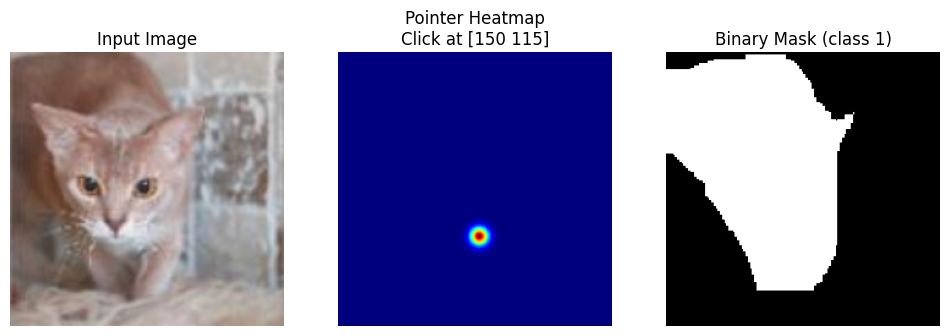

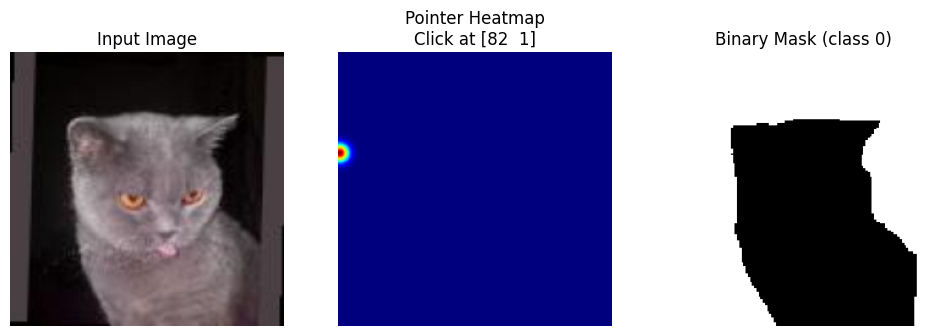

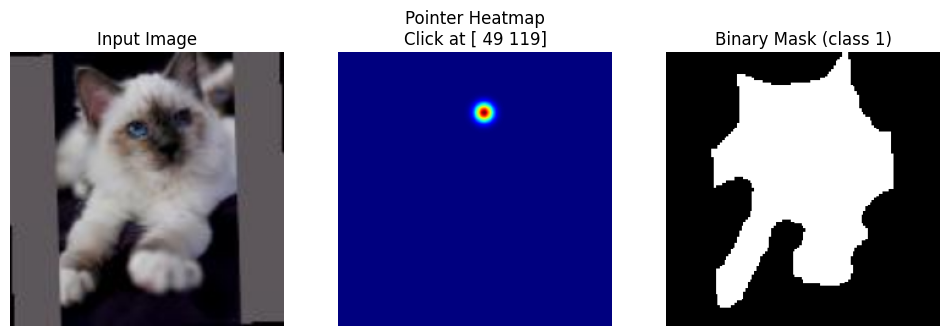

In [ ]:
import os
import re
import numpy as np
import torch
from torch.utils.data import Dataset, Subset  # Import Subset here.
from PIL import Image
import matplotlib.pyplot as plt

class PromptSegmentationDataset(Dataset):
    """
    A dataset for prompt-based (point-based) segmentation.

    For each image, a random valid click is sampled from one of the object regions
    (cat, dog, or background) ignoring boundary pixels (which are labeled 255).

    This class returns:
      - image: the transformed image
      - pointer_heatmap: a 1-channel tensor of shape [1, H, W] with a Gaussian centered at the click point
      - binary_mask: a binary ground-truth mask where pixels of the clicked object are 1 and all others are 0,
                     except that boundary pixels remain 255 (to be ignored in loss)
      - chosen_class: the label of the object that was clicked (for debugging)
      - click_coord: the (row, col) coordinate of the sampled click (for verification)
    """
    def __init__(self, root_dir, transform_img, transform_label=None, sigma=5):
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.sigma = sigma

        self.image_dir = os.path.join(root_dir, 'color')
        self.mask_dir = os.path.join(root_dir, 'label')

        # Filter image files to include only those with an existing mask file.
        self.image_paths = sorted([
            fname for fname in os.listdir(self.image_dir)
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')) and
               os.path.exists(os.path.join(self.mask_dir, os.path.splitext(fname)[0] + ".png"))
        ])
        if not self.image_paths:
            raise RuntimeError("No valid image files found with matching masks.")

    def __len__(self):
        return len(self.image_paths)

    def generate_gaussian_heatmap(self, shape, center, sigma):
        """
        Generate a 2D Gaussian heatmap over an image of given shape,
        with the Gaussian centered at 'center' (row, col) and standard deviation sigma.
        The heatmap is normalized so that the maximum value is 1.
        """
        H, W = shape
        y = np.arange(0, H)
        x = np.arange(0, W)
        xx, yy = np.meshgrid(x, y)
        heatmap = np.exp(-((xx - center[1])**2 + (yy - center[0])**2) / (2 * sigma**2))
        heatmap = heatmap / np.max(heatmap)
        return heatmap

    def __getitem__(self, index):
        image_filename = self.image_paths[index]
        image_path = os.path.join(self.image_dir, image_filename)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(image_filename)[0] + ".png")

        # Extra check: if file missing, skip sample.
        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"Warning: Missing file for sample {index}: {image_path} or {mask_path}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Error loading image {image_path}: {e}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))

        try:
            mask_img = Image.open(mask_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Error loading mask {mask_path}: {e}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))

        mask_np = np.array(mask_img, dtype=np.uint8)

        # Create a label map: background=0, cat=1, dog=2; else boundary=255.
        label_new = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)
        background_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 0) & (mask_np[..., 2] == 0)
        label_new[background_mask] = 0

        cat_mask = (mask_np[..., 0] == 255) & (mask_np[..., 1] == 165) & (mask_np[..., 2] == 0)
        label_new[cat_mask] = 1

        dog_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 255) & (mask_np[..., 2] == 255)
        label_new[dog_mask] = 2

        boundary_mask = ~(background_mask | cat_mask | dog_mask)
        label_new[boundary_mask] = 255

        # Optionally transform the label.
        if self.transform_label:
            label_tensor = torch.from_numpy(label_new).long()
            if label_tensor.ndim == 2:
                label_tensor = label_tensor.unsqueeze(0)
            label_tensor = self.transform_label(label_tensor)
            label_tensor = label_tensor.squeeze(0)
            label_new = label_tensor.numpy()

        # --- Sample a pointer click ---
        valid_mask = (label_new != 255)
        if np.sum(valid_mask) == 0:
            print(f"Warning: No valid (non-boundary) pixels for sample {index}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))
        valid_labels = label_new[valid_mask]
        classes = np.unique(valid_labels)
        chosen_class = np.random.choice(classes)
        coords = np.argwhere(label_new == chosen_class)
        if coords.size == 0:
            print(f"Warning: No pixels with chosen class {chosen_class} for sample {index}. Skipping sample.")
            return self.__getitem__((index + 1) % len(self))
        click_coord = coords[np.random.randint(len(coords))]

        # Generate pointer heatmap.
        pointer_heatmap = self.generate_gaussian_heatmap(label_new.shape, click_coord, self.sigma)
        assert np.isclose(np.max(pointer_heatmap), 1.0, atol=1e-4), "Pointer heatmap not normalized correctly."
        pointer_heatmap = torch.from_numpy(pointer_heatmap).float()

        # Create binary ground truth.
        binary_mask = np.where(label_new == chosen_class, 1, 0)
        binary_mask[label_new == 255] = 255
        binary_mask = torch.from_numpy(binary_mask).long()

        if self.transform_img:
            image = self.transform_img(image)

        return image, pointer_heatmap.unsqueeze(0), binary_mask, chosen_class, click_coord

def verify_prompt_dataset(dataset, num_samples=3):
    """
    Visualizes a few samples from the PromptSegmentationDataset to verify that:
      - The pointer heatmap peaks at the sampled click location.
      - The binary ground truth mask correctly labels the object region.
    """
    for i in range(num_samples):
        image, pointer_heatmap, binary_mask, chosen_class, click_coord = dataset[i]

        # Convert image tensor to a numpy array (assuming CHW -> HWC).
        if torch.is_tensor(image):
            img_np = image.cpu().permute(1, 2, 0).numpy()
        else:
            img_np = np.array(image)

        # Plot the results.
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pointer_heatmap.squeeze(0).cpu().numpy(), cmap='jet')
        plt.title(f"Pointer Heatmap\nClick at {click_coord}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(binary_mask.cpu().numpy(), cmap='gray')
        plt.title(f"Binary Mask (class {chosen_class})")
        plt.axis('off')

        plt.show()

# -------------------------------
# Example of a fast verification run:
if __name__ == "__main__":
    # For testing, you can use CLIP's preprocessing transform for images.
    import torchvision.transforms as T
    from torchvision.transforms import Compose, Resize, ToTensor

    # Define transforms (adjust dimensions as needed).
    transform_img = Compose([
        Resize((224, 224)),
        ToTensor()
    ])
    transform_label = Resize((224, 224), interpolation=T.InterpolationMode.NEAREST)

    # Instantiate the prompt-based dataset.
    # (Be sure to set root_dir to the proper path for your dataset.)
    prompt_dataset = PromptSegmentationDataset(
        root_dir="/content/processed_3/TrainVal",
        transform_img=transform_img,
        transform_label=transform_label,
        sigma=5  # Adjust sigma to change the spread of the heatmap.
    )

    # Select specific indices for quick validation.
    desired_indices = [353, 2619, 1619]
    subset_dataset = Subset(prompt_dataset, desired_indices)

    # Run the verification function using the subset.
    verify_prompt_dataset(subset_dataset, num_samples=len(desired_indices))

## CLIP features model architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # For interpolation
import numpy as np

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y
###########################################
# 1. Pointer Encoder Module
###########################################

class PointerEncoder(nn.Module):
    """
    A small CNN that projects the pointer heatmap (1 channel)
    to a feature map with the same channel dimension as the CLIP features.
    """
    def __init__(self, in_channels=1, out_channels=768, kernel_size=3, padding=1):
        super(PointerEncoder, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # x: [B, 1, H, W] pointer heatmap; should be normalized (peak ~1)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

###########################################
# 2. Revised Segmentation Head without Text
###########################################

class ImprovedCLIPSegmentationHeadWithPointer(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_prob=0.25, use_attention=True):
        super(ImprovedCLIPSegmentationHeadWithPointer, self).__init__()
        # Concatenate: image features + pointer features = 2 * in_channels.
        self.fuse_conv1 = nn.Sequential(
            nn.Conv2d(in_channels * 2, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)
        )
        self.residual_block = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
        )
        self.relu = nn.ReLU(inplace=True)
        self.attention = ChannelAttention(256) if use_attention else nn.Identity()
        self.fuse_conv2 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, img_features, pointer_features):
        B, C, H, W = img_features.shape  # Expected C = 768
        # Ensure features are float.
        img_features = img_features.float()
        pointer_features = pointer_features.float()

        # Concatenate image and pointer features along the channel dimension.
        fused = torch.cat([img_features, pointer_features], dim=1)
        x = self.fuse_conv1(fused)
        res = self.residual_block(x)
        x = self.relu(x + res)
        x = self.attention(x)
        logits = self.fuse_conv2(x)
        return logits

###########################################
# 3. Modified CLIPSegmentationModel with Pointer Only
###########################################

class CLIPSegmentationModelWithPointer(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super(CLIPSegmentationModelWithPointer, self).__init__()
        # Get feature dimension from the CLIP visual model (e.g., 768).
        self.feature_dim = clip_model.visual.output_dim
        print(f'Feature dimension: {self.feature_dim}')  # Expected 768

        self.clip_model = clip_model
        # Freeze CLIP backbone.
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # Instantiate the pointer encoder.
        self.pointer_encoder = PointerEncoder(in_channels=1, out_channels=self.feature_dim)

        # Revised segmentation head: only fuse image and pointer features.
        self.seg_head = ImprovedCLIPSegmentationHeadWithPointer(
            in_channels=self.feature_dim,
            num_classes=num_classes,
            dropout_prob=0.25
        )

    def get_visual_features(self, image):
        visual = self.clip_model.visual
        image = image.to(dtype=visual.conv1.weight.dtype)
        x = visual.conv1(image)  # [B, width, H', W']
        x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)  # [B, tokens, width]
        cls_tokens = visual.class_embedding.to(x.dtype) + torch.zeros(
            x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + visual.positional_embedding.to(x.dtype)
        x = visual.ln_pre(x)
        x = x.permute(1, 0, 2)
        x = visual.transformer(x)
        x = x.permute(1, 0, 2)
        if hasattr(visual, "proj"):
            x = x @ visual.proj
        return x

    def forward(self, image, pointer_heatmap):
        image = image.float()
        # Compute CLIP features without gradients.
        with torch.no_grad():
            visual_features = self.get_visual_features(image)  # [B, num_tokens+1, 768]
            tokens = visual_features[:, 1:, :]  # Remove the class token.
            B, N, D = tokens.shape
            grid_size = int(np.sqrt(N))
            image_features = tokens.reshape(B, grid_size, grid_size, D).permute(0, 3, 1, 2)  # [B, 768, grid_size, grid_size]

            # Process pointer heatmap via pointer encoder.
            pointer_features = self.pointer_encoder(pointer_heatmap)  # [B, 768, H, W] (e.g. H=W=224)
            # Downsample pointer_features to match grid_size (e.g. 16x16).
            pointer_features = F.interpolate(pointer_features, size=(grid_size, grid_size), mode='bilinear', align_corners=False)

        # Fuse image and pointer features in the segmentation head.
        seg_logits = self.seg_head(image_features, pointer_features)
        seg_logits = F.interpolate(seg_logits, size=(image.shape[2], image.shape[3]),
                                   mode="bilinear", align_corners=False)
        return seg_logits

###########################################
# (Optional) Sanity Verification for Pointer Branch
###########################################

def verify_pointer_branch(model, sample_image, sample_pointer_heatmap):
    """
    A quick check to verify the pointer branch:
      - Ensures that the pointer heatmap is processed into the correct feature shape.
      - Verifies that the segmentation head fuses the pointer features correctly.
    """
    model.eval()
    with torch.no_grad():
        seg_logits = model(sample_image, sample_pointer_heatmap)
        print("Segmentation logits shape:", seg_logits.shape)
    # Expected seg_logits shape: [B, num_classes, H, W]
    return seg_logits


class ImprovedCLIPSegmentationHead(nn.Module):
    def __init__(self, in_channels, text_dim, num_classes, dropout_prob=0.25, use_attention=True):
        super(ImprovedCLIPSegmentationHead, self).__init__()
        # Project text features to match visual feature channels.
        self.text_proj = nn.Linear(text_dim, in_channels)
        self.fuse_conv1 = nn.Sequential(
            nn.Conv2d(in_channels * 2, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)
        )
        self.residual_block = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
        )
        self.relu = nn.ReLU(inplace=True)
        self.attention = ChannelAttention(256) if use_attention else nn.Identity()
        self.fuse_conv2 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, img_features, text_features):
        B, C, H, W = img_features.shape  # Expected C = 768
        img_features = img_features.float()
        text_features = text_features.float()

        projected_text = self.text_proj(text_features)  # [B, 768]
        projected_text = projected_text.view(B, C, 1, 1).expand(B, C, H, W)
        fused = torch.cat([img_features, projected_text], dim=1)
        x = self.fuse_conv1(fused)
        res = self.residual_block(x)
        x = self.relu(x + res)
        x = self.attention(x)
        logits = self.fuse_conv2(x)
        return logits

class CLIPSegmentationModel(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super(CLIPSegmentationModel, self).__init__()
        # Get feature dimension from the CLIP visual model (e.g., 768).
        self.feature_dim = clip_model.visual.output_dim
        print(f'Feature dimension: {self.feature_dim}')  # Expected 768

        self.clip_model = clip_model
        # Segmentation head with input channels and text dimension matching CLIP.
        self.seg_head = ImprovedCLIPSegmentationHead(
            in_channels=self.feature_dim,
            text_dim=self.feature_dim,
            num_classes=num_classes,
            dropout_prob=0.25
        )

    def get_visual_features(self, image):
        visual = self.clip_model.visual
        image = image.to(dtype=visual.conv1.weight.dtype)
        x = visual.conv1(image)  # [B, width, H', W']
        x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)  # [B, tokens, width]
        cls_tokens = visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + visual.positional_embedding.to(x.dtype)
        x = visual.ln_pre(x)
        x = x.permute(1, 0, 2)
        x = visual.transformer(x)
        x = x.permute(1, 0, 2)
        if hasattr(visual, "proj"):
            x = x @ visual.proj
        return x

    def forward(self, image, token_ids):
      image = image.float()
      # Compute CLIP features without tracking gradients.
      with torch.no_grad():
          visual_features = self.get_visual_features(image)  # [B, num_tokens+1, 768]
          tokens = visual_features[:, 1:, :]  # remove the class token
          B, N, D = tokens.shape
          grid_size = int(np.sqrt(N))
          image_features = tokens.reshape(B, grid_size, grid_size, D).permute(0, 3, 1, 2)
          text_features = self.clip_model.encode_text(token_ids).float()

      # Compute segmentation head normally (gradients tracked here).
      seg_logits = self.seg_head(image_features, text_features)
      seg_logits = F.interpolate(seg_logits, size=(image.shape[2], image.shape[3]),
                                mode="bilinear", align_corners=False)
      return seg_logits

In [ ]:

###########################################
# Integration and Fast Verification
###########################################
#
# 1. Insert these new classes (PointerEncoder, ImprovedCLIPSegmentationHeadWithPointer,
#    and CLIPSegmentationModelWithPointer) into your model definition file.
#
# 2. In your training/testing scripts, replace the old CLIPSegmentationModel with this new
#    CLIPSegmentationModelWithPointer. Also, update your data loader to provide only an image
#    and a pointer heatmap (no text tokens).
#
# 3. To run a fast verification:
#    - Prepare a dummy batch (or use one sample from your prompt-based dataset) that returns:
#         image: [B, 3, H, W]
#         pointer_heatmap: [B, 1, H, W] (with peak ~1)
#    - Then call verify_pointer_branch(model, image, pointer_heatmap)
#
# Example usage:
#
# Get a sample from your prompt dataset:
sample_image, sample_pointer_heatmap, _, _, _ = prompt_dataset[0]
sample_image = sample_image.unsqueeze(0)           # Add batch dimension.
sample_pointer_heatmap = sample_pointer_heatmap.unsqueeze(0)

# Instantiate the model (assuming you have a loaded CLIP model).
model = CLIPSegmentationModelWithPointer(clip_model, num_classes=3).to(device)

# Run the verification function:
output_logits = verify_pointer_branch(model, sample_image, sample_pointer_heatmap)
# You should see printed shape information for the segmentation logits.

# This check verifies that the pointer branch is processed and fused correctly.

# (End of pointer branch implementation without text)

NameError: name 'clip_model' is not defined

In [ ]:
def quick_sanity_check_training(model_path, prompt_dataset):
    """
    A quick sanity check for the pointer-based model training setup:
      - Loads the pointer model and checkpoint (after filtering out keys that cause size mismatches).
      - Retrieves one sample from the prompt dataset.
      - Runs a forward pass and prints the shape of the segmentation logits.

    Expected output shape: [1, num_classes, H, W] (e.g., [1, 2, 224, 224])
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the CLIP model.
    clip_model, _ = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False

    # Instantiate the pointer-based segmentation model (with 2 classes).
    model = CLIPSegmentationModelWithPointer(clip_model=clip_model, num_classes=2).to(device)

    # Load the checkpoint and remove keys that don't match the new architecture.
    state_dict = torch.load(model_path, map_location=device)
    # Remove mismatched keys from the segmentation head final layer (expected for 2 classes)
    for key in list(state_dict.keys()):
        if "seg_head.fuse_conv2" in key:
            del state_dict[key]
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    # Get one sample from the prompt dataset.
    # Expected sample: (image, pointer_heatmap, binary_mask, chosen_class, click_coord)
    sample = prompt_dataset[0]
    sample_image, sample_pointer_heatmap = sample[0], sample[1]

    # Add batch dimension and move to device.
    sample_image = sample_image.unsqueeze(0).to(device)
    sample_pointer_heatmap = sample_pointer_heatmap.unsqueeze(0).to(device)

    # Run a forward pass.
    with torch.no_grad():
        seg_logits = model(sample_image, sample_pointer_heatmap)
        print("Segmentation logits shape:", seg_logits.shape)

    print("Quick training sanity check complete.")
    return seg_logits

# Example usage:
if __name__ == "__main__":
    # Replace with the correct path to your model checkpoint.
    model_path = "/content/pointer_model_best.pth"

    # Assume prompt_dataset is already instantiated from your PromptSegmentationDataset.
    # For example:
    # prompt_dataset = PromptSegmentationDataset(root_dir="/content/processed_3/TrainVal",
    #                                            transform_img=your_img_transform,
    #                                            transform_label=your_label_transform,
    #                                            sigma=5)

    if os.path.exists(model_path):
        quick_sanity_check_training(model_path, prompt_dataset)
    else:
        print("No checkpoint found for quick sanity check.")

No checkpoint found for quick sanity check.


## Helper Functions

In [ ]:


###############################################
#        Metric Helper Functions              #
###############################################



def compute_iou(preds, targets, num_classes=3, smooth=1e-6):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection + smooth) / (union + smooth))
    return ious


def compute_dice(preds, targets, num_classes=3, smooth=1e-6):
    dice_scores = []
    for cls in range(num_classes):
        pred_c = (preds == cls).float()
        target_c = (targets == cls).float()
        intersection = (pred_c * target_c).sum().float()
        union = pred_c.sum() + target_c.sum()
        if union == 0:
            dice_scores.append(float('nan'))
        else:
            dice_scores.append((2 * intersection + smooth) / (union + smooth))
    dice_tensor = torch.tensor(dice_scores, dtype=torch.float32)
    avg_dice = torch.nanmean(dice_tensor).item()
    return avg_dice, dice_tensor

def pixel_accuracy(output, target):
    """
    Computes pixel accuracy given the model output and target.
    output: logits tensor of shape [N, C, H, W]
    target: ground truth tensor of shape [N, H, W]
    """
    _, preds = torch.max(output, dim=1)
    correct = (preds == target).float().sum().item()
    return correct / torch.numel(target)


###############################################
#           Save Metrics to CSV               #
###############################################

def save_metrics(metrics, test_loss, test_acc, test_iou, test_dice, filepath):
    fieldnames = [
        'epoch', 'train_loss', 'train_acc',
        'val_loss', 'val_acc',
        'val_iou_avg', 'val_iou_class0', 'val_iou_class1', 'val_iou_class2',
        'val_dice_avg', 'val_dice_class0', 'val_dice_class1', 'val_dice_class2',
        'test_loss', 'test_acc', 'test_iou', 'test_dice_avg'
    ]
    with open(filepath, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for m in metrics:
            writer.writerow({
                'epoch': m.get('epoch', ''),
                'train_loss': m.get('train_loss', ''),
                'train_acc': m.get('train_acc', ''),
                'val_loss': m.get('val_loss', ''),
                'val_acc': m.get('val_acc', ''),
                'val_iou_avg': m.get('val_iou_avg', ''),
                'val_iou_class0': m.get('val_iou_class0', ''),
                'val_iou_class1': m.get('val_iou_class1', ''),
                'val_iou_class2': m.get('val_iou_class2', ''),
                'val_dice_avg': m.get('val_dice_avg', ''),
                'val_dice_class0': m.get('val_dice_class0', ''),
                'val_dice_class1': m.get('val_dice_class1', ''),
                'val_dice_class2': m.get('val_dice_class2', ''),
                'test_loss': '',
                'test_acc': '',
                'test_iou': '',
                'test_dice_avg': ''
            })
        writer.writerow({
            'epoch': 'test',
            'train_loss': '',
            'train_acc': '',
            'val_loss': '',
            'val_acc': '',
            'val_iou_avg': '',
            'val_iou_class0': '',
            'val_iou_class1': '',
            'val_iou_class2': '',
            'val_dice_avg': '',
            'val_dice_class0': '',
            'val_dice_class1': '',
            'val_dice_class2': '',
            'test_loss': test_loss,
            'test_acc': test_acc,
            'test_iou': test_iou,
            'test_dice_avg': test_dice
        })


###############################################
#         Updated Validation Function         #
###############################################

def validate_epoch(model, dataloader, device, num_classes=3):
    model.eval()
    running_loss, running_correct = 0.0, 0.0
    total_pixels = 0
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks, token_ids in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            token_ids = token_ids.to(device)
            outputs = model(images, token_ids)
            loss = nn.CrossEntropyLoss()(outputs, masks)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            running_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = running_correct / total_pixels
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    iou_list = compute_iou(all_preds, all_masks, num_classes)
    avg_iou = np.nanmean(iou_list)
    avg_dice, dice_tensor = compute_dice(all_preds, all_masks, num_classes)

    # For saving per-class metrics:
    iou_class0 = iou_list[0]
    iou_class1 = iou_list[1]
    iou_class2 = iou_list[2]
    dice_class0 = dice_tensor[0].item()
    dice_class1 = dice_tensor[1].item()
    dice_class2 = dice_tensor[2].item()

    return val_loss, val_acc, avg_iou, iou_list, avg_dice, [dice_class0, dice_class1, dice_class2]


def denormalize(image_tensor):
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean
    image_tensor = torch.clamp(image_tensor, 0, 1)
    return image_tensor

def has_nan_or_inf(tensor, name="Tensor"):
    """Checks if a tensor contains NaN or Inf values and prints debug information."""
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}!")
        return True
    if torch.isinf(tensor).any():
        print(f"Inf detected in {name}!")
        return True
    return False

###############################################
#           Testing Function (Example)        #
###############################################

def test_model_fn(model_path, test_dataset, batch_size=16, num_classes=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255).to(device)

    # Reload the CLIP model for testing.
    clip_model, _ = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False

    model = CLIPSegmentationModel(clip_model=clip_model, num_classes=num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    running_loss, running_correct, total_pixels = 0.0, 0, 0
    all_preds, all_masks = [], []
    with torch.no_grad():
        for images, masks, token_ids in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            token_ids = token_ids.to(device)
            outputs = model(images, token_ids)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            running_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    avg_loss = running_loss / len(test_dataset)
    test_acc = running_correct / total_pixels
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    iou_list = compute_iou(all_preds, all_masks, num_classes)
    avg_iou = np.nanmean(iou_list)
    avg_dice, dice_tensor = compute_dice(all_preds, all_masks, num_classes)
    print(f"Test Loss: {avg_loss:.4f}, Test Acc: {test_acc:.4f}, Test IoU: {avg_iou:.4f}, Test Dice: {avg_dice:.4f}")
    return avg_loss, test_acc, avg_iou, avg_dice



## Training function

In [ ]:

###############################################
#       Updated Training Function             #
###############################################

def train_real_model(epochs=100, batch_size=16, patience=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    torch.autograd.set_detect_anomaly(True)
    torch.backends.cudnn.benchmark = True

    # Load the pretrained CLIP model and its preprocessing transform.
    clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False

    transform_img = clip_preprocess
    transform_label = T.Resize((224, 224), interpolation=T.InterpolationMode.NEAREST)

    train_dataset = SegmentationDatasetWithText(
        root_dir='/content/Dataset/processed/TrainVal/',
        transform_img=transform_img,
        transform_label=transform_label
    )
    indices = list(range(len(train_dataset)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_set = Subset(train_dataset, train_idx)
    val_set = Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

    model = CLIPSegmentationModel(clip_model=clip_model, num_classes=3).to(device)

    optimizer = torch.optim.Adam(model.seg_head.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = torch.nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    best_model_path = "clip_OPENAI_segmentation_best.pth"
    metrics = []
    overall_start = time.time()
    patience_counter = 0

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_pixels = 0
        epoch_start = time.time()
        scaler = torch.amp.GradScaler(device=device)

        for batch_idx, (images, masks, token_ids) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            token_ids = token_ids.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                seg_logits = model(images, token_ids)
                loss = criterion(seg_logits, masks)

            if has_nan_or_inf(seg_logits, "seg_logits") or has_nan_or_inf(loss, "loss"):
                print(f"Batch {batch_idx}: Skipping due to NaN/Inf values.")
                continue

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(seg_logits, dim=1)
            running_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)

            elapsed = time.time() - epoch_start
            progress = (batch_idx + 1) / len(train_loader)
            eta = elapsed / progress - elapsed
            print(f"\rEpoch {epoch}/{epochs} - Batch {batch_idx+1}/{len(train_loader)}: Loss: {loss.item():.4f}, ETA: {eta:.2f}s", end="")
        print()

        train_loss = running_loss / len(train_set)
        train_acc = running_correct / total_pixels

        model.eval()
        val_loss, val_acc, avg_iou, iou_list, avg_dice, dice_list = validate_epoch(model, val_loader, device, num_classes=3)
        print(f"Epoch {epoch} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"  Val IoU Avg: {avg_iou:.4f}, IoU per class: {iou_list}")
        print(f"  Val Dice Avg: {avg_dice:.4f}, Dice per class: {dice_list}")

        metrics.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_iou_avg': avg_iou,
            'val_iou_class0': iou_list[0],
            'val_iou_class1': iou_list[1],
            'val_iou_class2': iou_list[2],
            'val_dice_avg': avg_dice,
            'val_dice_class0': dice_list[0],
            'val_dice_class1': dice_list[1],
            'val_dice_class2': dice_list[2]
        })

        save_metrics(metrics, test_loss='', test_acc='', test_iou='', test_dice='',
             filepath="/content/drive/MyDrive/training_metrics_CLIP_OpenAI.csv")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
            print("Validation loss improved, model saved.")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

        elapsed_overall = time.time() - overall_start
        avg_epoch_time = elapsed_overall / epoch
        eta_training = (epochs - epoch) * avg_epoch_time
        print(f"Estimated overall training time remaining: {eta_training:.2f}s")

        scheduler.step()

        # Optional: Visualize one validation sample.
        sample_idx = random.choice(range(len(val_set)))
        sample_img, sample_mask, sample_token_ids = val_set[sample_idx]
        sample_img_tensor = sample_img.unsqueeze(0).to(device)
        sample_token_ids_tensor = sample_token_ids.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(sample_img_tensor, sample_token_ids_tensor)
            sample_pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        sample_img_np = denormalize(sample_img).cpu().permute(1, 2, 0).numpy()
        sample_mask_np = sample_mask.cpu().numpy()
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(sample_img_np)
        plt.title(f"Epoch {epoch} Input")
        plt.subplot(1,3,2)
        plt.imshow(sample_mask_np, cmap='gray', vmin=0, vmax=2)
        plt.title("Ground Truth")
        plt.subplot(1,3,3)
        plt.imshow(sample_pred, cmap='gray', vmin=0, vmax=2)
        plt.title("Prediction")
        plt.suptitle(f"Epoch {epoch} Sample Visualization")
        plt.show()

    return best_model_path, metrics


###############################################
#                 Main Function               #
###############################################

def main():
    import argparse
    parser = argparse.ArgumentParser(description="Train CLIP-Segmentation Model")
    parser.add_argument("--epochs", type=int, default=100, help="Number of training epochs.")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training.")
    args, unknown = parser.parse_known_args()

    best_model_path, metrics = train_real_model(epochs=args.epochs, batch_size=args.batch_size, patience=20)

    # For testing, use CLIP's preprocessing.
    clip_model, clip_preprocess = clip.load("ViT-L/14", device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    test_transform = clip_preprocess
    test_dataset = SegmentationDatasetWithText(
        root_dir="./Dataset/processed/Test/color",
        transform_img=test_transform
    )
    test_loss, test_acc, test_iou, test_dice = test_model_fn(best_model_path, test_dataset, batch_size=args.batch_size)
    save_metrics(metrics, test_loss, test_acc, test_iou, test_dice, "/content/drive/MyDrive/training_metrics_CLIP_OpenAI.csv")
    print("Training complete. Metrics saved to training_metrics_CLIP_OpenAI.csv")

if __name__ == "__main__":
    main()

Using device: cuda


NameError: name 'clip' is not defined

## Prompt Based Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms as T

def train_pointer_model(epochs=100, batch_size=16, patience=10,
                        train_root="/content/processed_3/TrainVal",
                        checkpoint_path="/content/pointer_model_best.pth"):
    """
    Training procedure for the pointer-based segmentation model with resume functionality.
    This version saves a full checkpoint (model state, optimizer, epoch, best_val_loss)
    and resumes training if a checkpoint exists.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load CLIP model (backbone remains frozen)
    import clip  # make sure clip is imported if not already
    clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False

    # Define transforms – use CLIP’s preprocessing for images
    transform_img = clip_preprocess
    transform_label = T.Resize((224, 224), interpolation=T.InterpolationMode.NEAREST)

    # Instantiate the PromptSegmentationDataset for training.
    train_dataset = PromptSegmentationDataset(
        root_dir=train_root,
        transform_img=transform_img,
        transform_label=transform_label,
        sigma=5  # Adjust sigma for the pointer heatmap spread.
    )

    # Split into training and validation sets.
    indices = list(range(len(train_dataset)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_set = Subset(train_dataset, train_idx)
    val_set = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    # Instantiate the model.
    model = CLIPSegmentationModelWithPointer(clip_model=clip_model, num_classes=2).to(device)

    # Set optimizer to train only pointer_encoder and seg_head parameters.
    optimizer = torch.optim.Adam(
        list(model.pointer_encoder.parameters()) + list(model.seg_head.parameters()),
        lr=1e-4
    )

    # Use CrossEntropyLoss with ignore_index=255.
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # Initialize training state variables.
    start_epoch = 1
    best_val_loss = float('inf')
    patience_counter = 0

    # Check if a checkpoint exists and resume training.
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_val_loss = checkpoint['best_val_loss']
            print(f"Resuming training from epoch {start_epoch} with best_val_loss {best_val_loss:.4f}.")
        else:
            # Fallback if checkpoint only contains model weights.
            state_dict = checkpoint
            # Remove keys for seg_head.fuse_conv2 if they mismatch.
            for key in list(state_dict.keys()):
                if "seg_head.fuse_conv2" in key:
                    del state_dict[key]
            model.load_state_dict(state_dict, strict=False)
            print("Loaded existing checkpoint (partial load). Starting from epoch 1.")
    else:
        print("No existing checkpoint found. Training from scratch.")

    # Freeze CLIP backbone parameters.
    for param in model.clip_model.parameters():
        param.requires_grad = False

    # Training loop.
    for epoch in range(start_epoch, epochs + 1):
        model.train()
        running_loss = 0.0
        for images, pointer_heatmaps, binary_masks, _, _ in train_loader:
            images = images.to(device)
            pointer_heatmaps = pointer_heatmaps.to(device)
            binary_masks = binary_masks.to(device)

            optimizer.zero_grad()
            outputs = model(images, pointer_heatmaps)
            loss = criterion(outputs, binary_masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_set)
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}")

        # Validation loop.
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, pointer_heatmaps, binary_masks, _, _ in val_loader:
                images = images.to(device)
                pointer_heatmaps = pointer_heatmaps.to(device)
                binary_masks = binary_masks.to(device)
                outputs = model(images, pointer_heatmaps)
                loss = criterion(outputs, binary_masks)
                val_loss += loss.item() * images.size(0)
        val_loss = val_loss / len(val_set)
        print(f"Epoch {epoch}: Val Loss: {val_loss:.4f}")

        # Checkpointing and early stopping.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the full checkpoint.
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            patience_counter = 0
            print("Validation loss improved; checkpoint saved.")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return model
# ------------------------------------------------------------------------------
# Quick Sanity Check for the Training Setup
# ------------------------------------------------------------------------------
def quick_sanity_check_training(model_path, prompt_dataset):
    """
    A quick sanity check:
      - Loads the pointer-based model and its checkpoint (removing keys that mismatch).
      - Retrieves one sample from the prompt dataset.
      - Runs a forward pass and prints the segmentation logits shape.

    Expected shape: [1, num_classes, H, W] (e.g., [1, 2, 224, 224])
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load CLIP model.
    import clip
    clip_model, _ = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False
    # Instantiate the pointer model (with 2 classes).
    model = CLIPSegmentationModelWithPointer(clip_model=clip_model, num_classes=2).to(device)
    state_dict = torch.load(model_path, map_location=device)
    # Remove keys for seg_head.fuse_conv2 if they mismatch (checkpoint from a 3-class model).
    for key in list(state_dict.keys()):
        if "seg_head.fuse_conv2" in key:
            del state_dict[key]
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    sample = prompt_dataset[0]
    sample_image, sample_pointer_heatmap = sample[0], sample[1]
    sample_image = sample_image.unsqueeze(0).to(device)
    sample_pointer_heatmap = sample_pointer_heatmap.unsqueeze(0).to(device)
    with torch.no_grad():
        seg_logits = model(sample_image, sample_pointer_heatmap)
        print("Segmentation logits shape:", seg_logits.shape)
    print("Quick training sanity check complete.")
    return seg_logits



# ------------------------------------------------------------------------------
# Example usage:
if __name__ == "__main__":
    # Define paths.
    train_root = "/content/processed_3/TrainVal"  # Your training data directory.
    checkpoint_path = "/content/pointer_model_best.pth"  # Your checkpoint path.

    # Create the prompt dataset.
    transform_img = Compose([Resize((224, 224)), ToTensor()])
    transform_label = Resize((224, 224), interpolation=T.InterpolationMode.NEAREST)
    prompt_dataset = PromptSegmentationDataset(
        root_dir=train_root,
        transform_img=transform_img,
        transform_label=transform_label,
        sigma=5
    )

    # Run quick sanity check (make sure a checkpoint exists).
    model_path = "/content/pointer_model_best.pth"
    if os.path.exists(model_path):
        quick_sanity_check_training(model_path, prompt_dataset)
    else:
        print("No checkpoint found for quick sanity check.")

    # Train the pointer model.
    trained_model = train_pointer_model(epochs=100, batch_size=16, patience=10,
                                        train_root=train_root,
                                        checkpoint_path=checkpoint_path)


No checkpoint found for quick sanity check.
Using device: cuda


 33%|█████████████                          | 297M/890M [00:03<00:07, 84.0MiB/s]


KeyboardInterrupt: 

## Loading Weights Sanity Check

In [ ]:
import zipfile
from pathlib import Path

model_path = Path("/content/clip_OPENAI_segmentation_best.pth")
if zipfile.is_zipfile(model_path):
    print("Model file is a valid zip archive.")
else:
    print("Model file is not a valid zip archive. It may be corrupted or saved in a different format.")

Model file is a valid zip archive.


In [ ]:
with open(model_path, 'rb') as f:
    header = f.read(4)
    print("Header bytes:", header)

Header bytes: b'PK\x03\x04'


In [ ]:
import torch

try:
    checkpoint = torch.load(model_path, map_location="cpu")
    print("Checkpoint loaded successfully.")
    print("Keys in the checkpoint:", checkpoint.keys())
except Exception as e:
    print("Error loading checkpoint:", e)

Checkpoint loaded successfully.
Keys in the checkpoint: odict_keys(['clip_model.positional_embedding', 'clip_model.text_projection', 'clip_model.logit_scale', 'clip_model.visual.class_embedding', 'clip_model.visual.positional_embedding', 'clip_model.visual.proj', 'clip_model.visual.conv1.weight', 'clip_model.visual.ln_pre.weight', 'clip_model.visual.ln_pre.bias', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_weight', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_bias', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.weight', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_1.weight', 'clip_model.visual.transformer.resblocks.0.ln_1.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.bias', 'clip_model.visual.t

## Testing

In [ ]:
def test_model_with_visualizations(model_path, test_dataset, batch_size=16, num_classes=3, num_plots=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255).to(device)

    # Reload CLIP model for testing.
    clip_model, _ = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False

    # Create the segmentation model and load saved weights.
    model = CLIPSegmentationModel(clip_model=clip_model, num_classes=num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # Create test dataloader.
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    running_loss = 0.0
    running_correct = 0
    total_valid_pixels = 0
    all_preds, all_masks = [], []

    # Iterate over test batches for metric computation.
    with torch.no_grad():
        for images, masks, token_ids in test_loader:
            images = images.to(device)
            token_ids = token_ids.to(device)
            # For metrics: ignore pixels not in {0,1,2} (boundaries)
            masks_metric = masks.clone()
            masks_metric[~((masks_metric == 0) | (masks_metric == 1) | (masks_metric == 2))] = 255
            masks_metric = masks_metric.to(device)

            outputs = model(images, token_ids)
            loss = criterion(outputs, masks_metric)
            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            valid = (masks_metric != 255)
            running_correct += ((preds == masks_metric) & valid).sum().item()
            total_valid_pixels += valid.sum().item()

            all_preds.append(preds.cpu())
            all_masks.append(masks_metric.cpu())

    avg_loss = running_loss / len(test_dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    valid_mask = (all_masks != 255)
    valid_preds = all_preds[valid_mask]
    valid_targets = all_masks[valid_mask]
    pixel_acc = (valid_preds == valid_targets).sum().item() / valid_preds.numel()

    iou_list = compute_iou(valid_preds, valid_targets, num_classes)
    avg_iou = np.nanmean(iou_list)
    avg_dice, dice_tensor = compute_dice(valid_preds, valid_targets, num_classes)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"IoU per class: {iou_list}")
    print(f"Average Dice: {avg_dice:.4f}")
    print(f"Dice per class: {dice_tensor.tolist()}")

    # For predictions, use a colormap that maps:
    # 0 -> black (background), 1 -> orange (cat), 2 -> cyan (dog)
    cmap_pred = ListedColormap(['black', 'orange', 'cyan'])

    # For ground truth visualization, re-load the original mask from disk
    # and map colors as follows:
    # background (black) -> 0, cat (orange [255,165,0]) -> 1,
    # dog (cyan [0,255,255]) -> 2, and boundaries (anything else) -> 3.
    cmap_gt = ListedColormap(['black', 'orange', 'cyan', 'white'])

    # Include required sample indices so that the following pdf files are produced:
    # 'CLIP_sample_648.pdf', 'CLIP_sample_1358.pdf', 'CLIP_sample_602.pdf'
    indices = random.sample(range(len(test_dataset)), num_plots)
    required_indices = [353, 2619, 1619]
    indices = list(set(indices + required_indices))

    # Plot the input, ground truth, and prediction for the selected samples.
    for idx in indices:
        # Get the sample from the dataset.
        image, _, token_ids = test_dataset[idx]
        # Re-load the original mask from file using the dataset's paths.
        mask_filename = test_dataset.image_paths[idx]
        mask_path = os.path.join(test_dataset.mask_dir, Path(mask_filename).stem + ".png")
        mask_img = Image.open(mask_path).convert("RGB")
        mask_np = np.array(mask_img, dtype=np.uint8)

        # Build the ground truth visualization mask.
        # Assign labels: background -> 0, cat -> 1, dog -> 2, boundary -> 3.
        gt_vis = np.zeros(mask_np.shape[:2], dtype=np.int64)
        background_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 0) & (mask_np[..., 2] == 0)
        cat_mask = (mask_np[..., 0] == 255) & (mask_np[..., 1] == 165) & (mask_np[..., 2] == 0)
        dog_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 255) & (mask_np[..., 2] == 255)
        gt_vis[background_mask] = 0
        gt_vis[cat_mask] = 1
        gt_vis[dog_mask] = 2
        boundary_mask = ~(background_mask | cat_mask | dog_mask)
        gt_vis[boundary_mask] = 3

        # Get model prediction for the sample.
        image_tensor = image.unsqueeze(0).to(device)
        token_ids_tensor = token_ids.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor, token_ids_tensor)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Denormalize the image.
        img_np = denormalize(image).cpu().permute(1, 2, 0).numpy()

        # Plot the input, ground truth, and prediction.
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.subplot(1, 3, 2)
        plt.imshow(gt_vis, cmap=cmap_gt, vmin=-0.5, vmax=3.5)
        plt.title("Ground Truth")
        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap=cmap_pred, vmin=-0.5, vmax=2.5)
        plt.title("Prediction")
        plt.savefig(f"CLIP_sample_{idx}.pdf")
        plt.show()

    return pixel_acc, avg_iou, iou_list, avg_dice, dice_tensor


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load CLIP's preprocessing transform.
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
test_transform = clip_preprocess

# Create your test dataset.
# Update the root_dir to point to your test set directory.
test_dataset = SegmentationDatasetWithText(
    root_dir="/content/processed_3/Test",
    transform_img=test_transform,
    transform_label=T.Resize((224, 224), interpolation=T.InterpolationMode.NEAREST)
)

# Define the path to your saved model.
model_path = "/content/drive/MyDrive/pointer_model_best.pth"  # or the appropriate path to your checkpoint

# Call the testing function.
pixel_acc, avg_iou, iou_list, avg_dice, dice_tensor = test_model_with_visualizations(
    model_path=model_path,
    test_dataset=test_dataset,
    batch_size=8,
    num_classes=3,
    num_plots=10
)

NameError: name 'clip' is not defined

In [ ]:
import fitz  # PyMuPDF
from PIL import Image

def merge_pdfs_to_single_page(pdf_list, output_path, dpi=150):
    """
    Render each first page of the PDFs as an image, then stitch them vertically
    into one image, and save as a single-page PDF.

    Arguments:
      pdf_list: list of PDF file paths.
      output_path: path to save the merged PDF.
      dpi: resolution for rendering.
    """
    images = []
    for pdf in pdf_list:
        doc = fitz.open(pdf)
        page = doc.load_page(0)
        # Compute zoom factor from default 72 dpi to desired dpi.
        zoom = dpi / 72.0
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        # Convert pixmap to a PIL Image (RGB)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
        doc.close()

    # Calculate the maximum width and total height for vertical stacking.
    widths, heights = zip(*(im.size for im in images))
    max_width = max(widths)
    total_height = sum(heights)

    # Create a new blank image with white background.
    merged_img = Image.new('RGB', (max_width, total_height), color=(255, 255, 255))

    # Paste each image one below the other.
    y_offset = 0
    for im in images:
        merged_img.paste(im, (0, y_offset))
        y_offset += im.height

    # Save the merged image as a PDF.
    merged_img.save(output_path, "PDF", resolution=dpi)
    print(f"Merged PDF saved as {output_path}")

if __name__ == '__main__':
    pdf_files = ['CLIP_sample_353.pdf', 'CLIP_sample_2619.pdf', 'CLIP_sample_1619.pdf']
    output_pdf = 'CLIP_prediction_examples.pdf'
    merge_pdfs_to_single_page(pdf_files, output_pdf, dpi=150)

FileNotFoundError: no such file: 'CLIP_sample_353.pdf'

## Evaluation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import random

# ---------------------------
# Helper Metric Functions
# ---------------------------

def compute_iou(preds, targets, num_classes=2, smooth=1e-6):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection + smooth) / (union + smooth))
    return ious

def compute_dice(preds, targets, num_classes=2, smooth=1e-6):
    dice_scores = []
    for cls in range(num_classes):
        pred_c = (preds == cls).float()
        target_c = (targets == cls).float()
        intersection = (pred_c * target_c).sum().float()
        union = pred_c.sum() + target_c.sum()
        if union == 0:
            dice_scores.append(float('nan'))
        else:
            dice_scores.append((2 * intersection + smooth) / (union + smooth))
    dice_tensor = torch.tensor(dice_scores, dtype=torch.float32)
    avg_dice = torch.nanmean(dice_tensor).item()
    return avg_dice, dice_tensor

def pixel_accuracy(output, target):
    _, preds = torch.max(output, dim=1)
    correct = (preds == target).float().sum().item()
    return correct / torch.numel(target)

# ---------------------------
# Testing/Evaluation Function
# ---------------------------

def test_pointer_model(model_path, test_dataset, batch_size=8, num_classes=2):
    """
    Evaluates the pointer-based segmentation model on a test dataset.

    Loads the model weights from `model_path` (which should be /content/pointer_model_best.pth),
    then computes loss, pixel accuracy, IoU and Dice scores over the test set.

    Expected output: prints loss, accuracy, IoU and Dice scores and returns these metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load CLIP model.
    import clip
    clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False

    # Instantiate your pointer-based segmentation model (using the class you defined earlier).
    # (Here we assume your model class is CLIPSegmentationModelWithPointer.)
    model = CLIPSegmentationModelWithPointer(clip_model=clip_model, num_classes=num_classes).to(device)

    # Load the saved checkpoint.
    state_dict = torch.load(model_path, map_location=device)
    # (If needed, remove keys that do not match the new architecture.)
    for key in list(state_dict.keys()):
        if "seg_head.fuse_conv2" in key and state_dict[key].shape[0] != num_classes:
            del state_dict[key]
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    criterion = nn.CrossEntropyLoss(ignore_index=255).to(device)
    running_loss, running_correct, total_pixels = 0.0, 0, 0
    all_preds, all_masks = [], []

    with torch.no_grad():
        for images, pointer_heatmaps, binary_masks, _, _ in test_loader:
            images = images.to(device)
            pointer_heatmaps = pointer_heatmaps.to(device)
            binary_masks = binary_masks.to(device)

            outputs = model(images, pointer_heatmaps)
            loss = criterion(outputs, binary_masks)
            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            valid = (binary_masks != 255)
            running_correct += ((preds == binary_masks) & valid).sum().item()
            total_pixels += valid.sum().item()

            all_preds.append(preds.cpu())
            all_masks.append(binary_masks.cpu())

    avg_loss = running_loss / len(test_dataset)
    test_acc = running_correct / total_pixels
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    iou_list = compute_iou(all_preds, all_masks, num_classes=num_classes)
    avg_iou = np.nanmean(iou_list)
    avg_dice, dice_tensor = compute_dice(all_preds, all_masks, num_classes=num_classes)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Pixel Accuracy: {test_acc:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"IoU per class: {iou_list}")
    print(f"Average Dice: {avg_dice:.4f}")
    print(f"Dice per class: {dice_tensor.tolist()}")

    return avg_loss, test_acc, avg_iou, avg_dice

# ---------------------------
# Inference Function
# ---------------------------

def inference_example(model_path, image, click_coord, clip_model_instance=None):
    """
    Runs inference on a single image given a click coordinate.

    Steps:
      1. Convert the click coordinate into a pointer heatmap (using a Gaussian).
      2. Preprocess the image using CLIP's preprocessing.
      3. Load the pointer model from `model_path` and perform inference.
      4. Returns the segmentation mask (as the predicted class for each pixel).

    Expected output shape: [1, H, W] (e.g., [1, 224, 224])
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Assume image is a PIL image; apply CLIP's preprocessing.
    import clip
    if clip_model_instance is None:
        clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
    else:
        clip_model = clip_model_instance
        _, clip_preprocess = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False

    # Preprocess the image.
    processed_image = clip_preprocess(image).unsqueeze(0).to(device)
    # Create a pointer heatmap from the click coordinate.
    # Here, we assume the image size is 224x224 (since CLIP preprocessing resizes it).
    H, W = 224, 224
    y = np.arange(0, H)
    x = np.arange(0, W)
    xx, yy = np.meshgrid(x, y)
    sigma = 5  # Adjust sigma as needed.
    pointer_heatmap_np = np.exp(-((xx - click_coord[1])**2 + (yy - click_coord[0])**2) / (2 * sigma**2))
    pointer_heatmap_np = pointer_heatmap_np / np.max(pointer_heatmap_np)
    pointer_heatmap = torch.from_numpy(pointer_heatmap_np).unsqueeze(0).unsqueeze(0).float().to(device)

    # Load the pointer model.
    model = CLIPSegmentationModelWithPointer(clip_model=clip_model, num_classes=2).to(device)
    state_dict = torch.load(model_path, map_location=device)
    for key in list(state_dict.keys()):
        if "seg_head.fuse_conv2" in key and state_dict[key].shape[0] != 2:
            del state_dict[key]
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    with torch.no_grad():
        outputs = model(processed_image, pointer_heatmap)
        pred_mask = torch.argmax(outputs, dim=1)

    print("Inference completed. Predicted mask shape:", pred_mask.shape)
    return pred_mask

# ---------------------------
# Explanation and Context
# ---------------------------
#
# You should add the above testing/evaluation and inference functions to your training/evaluation
# module. They work as follows:
#
# - `test_pointer_model(...)` loads the pointer-based model from the checkpoint
#   `/content/pointer_model_best.pth`, then iterates over the test dataset (which should be built
#   from your PromptSegmentationDataset) and computes segmentation loss, pixel accuracy, IoU, and Dice.
#
#   Expected printed outputs include the test loss, pixel accuracy, average IoU, and Dice scores.
#
# - `inference_example(...)` demonstrates how to use the model in an inference scenario:
#   it takes a single image (as a PIL image) and a click coordinate (e.g., (row, col) on the 224×224 image),
#   converts the click into a Gaussian pointer heatmap, and runs the model to produce a segmentation mask.
#
# **How to Run the Fast Verification Check:**
#
# 1. For testing/evaluation, call:
#
#      test_pointer_model("/content/pointer_model_best.pth", test_dataset)
#
#    where `test_dataset` is an instance of your test dataset (built using PromptSegmentationDataset).
#
# 2. For inference, pass a PIL image and a click coordinate. For example:
#
#      from PIL import Image
#      test_img = Image.open("/path/to/your/test/image.jpg").convert("RGB")
#      # Suppose the user clicked at (100, 120) on the 224x224 image:
#      pred_mask = inference_example("/content/pointer_model_best.pth", test_img, (100, 120))
#
#    This will print the predicted mask shape (expected: [1, 224, 224]) and return the predicted mask.
#
# These functions give you both quantitative evaluation (loss, accuracy, IoU, Dice) and a qualitative
# inference example to verify that your pointer-based segmentation model behaves as expected.
#
# ---------------------------
# Example Usage:
# ---------------------------
if __name__ == "__main__":
    # Assume you have already created your test dataset from PromptSegmentationDataset.
    # For example:
    test_dataset = PromptSegmentationDataset(
        root_dir="/content/processed_3/Test",
        transform_img=Compose([Resize((224, 224)), ToTensor()]),
        transform_label=Resize((224, 224), interpolation=T.InterpolationMode.NEAREST),
        sigma=5
    )

    # Run evaluation on the test dataset.
    test_loss, test_acc, avg_iou, avg_dice = test_pointer_model("/content/drive/MyDrive/pointer_model_best.pth", test_dataset)

    # For an inference example, load an image and simulate a click:
    from PIL import Image
    test_img = Image.open("/content/processed_3/Test/color/cat_Abyssinian_2.jpg").convert("RGB")
    # For example, assume a click at coordinate (110, 130) on the resized image.
    pred_mask = inference_example("/content/drive/MyDrive/pointer_model_best.pth", test_img, (110, 130))


/usr/local/lib/python3.11/dist-packages/clip/clip.py:57: UserWarning: /root/.cache/clip/ViT-L-14.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")
  7%|██▊                                   | 64.5M/890M [00:00<00:09, 90.5MiB/s]


KeyboardInterrupt: 

## Visualization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import clip  # Make sure CLIP is installed and imported

def visualize_inference_examples(model_path, dataset, num_examples=3, output_pdf="inference_examples.pdf"):
    """
    Visualizes several inference examples from a pointer-based segmentation model
    and saves the combined output as a single continuous PDF page.

    For each selected sample from the dataset, this function:
      - Loads the image and corresponding pointer heatmap.
      - Runs a forward pass using the loaded model weights from `model_path`.
      - Displays the input image, the pointer heatmap, the ground truth binary mask,
        and the predicted segmentation mask.

    All samples are arranged together in one large figure that is saved as one PDF.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the CLIP model (frozen) and instantiate your pointer-based segmentation model.
    clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
    clip_model.eval()
    for param in clip_model.parameters():
        param.requires_grad = False

    # Instantiate the pointer model.
    # (Assumes your pointer model class is CLIPSegmentationModelWithPointer.)
    # Set num_classes=2 for binary output (foreground vs. background).
    model = CLIPSegmentationModelWithPointer(clip_model=clip_model, num_classes=2).to(device)

    # Load the checkpoint from model_path.
    state_dict = torch.load(model_path, map_location=device)
    # Remove mismatched keys from the final layer (if the checkpoint is for 3 classes).
    for key in list(state_dict.keys()):
        if "seg_head.fuse_conv2" in key and state_dict[key].shape[0] != 2:
            del state_dict[key]
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    # Use fixed indices.
    indices = [353, 2619, 1619]

    # Create a single figure with one row per sample and 4 columns.
    fig, axes = plt.subplots(nrows=len(indices), ncols=4, figsize=(12, 4 * len(indices)))

    # If only one sample is provided, ensure axes is 2D.
    if len(indices) == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(indices):
        # Get the sample from the dataset.
        # Expected: (image, pointer_heatmap, binary_mask, chosen_class, click_coord)
        sample = dataset[idx]
        image, pointer_heatmap, binary_mask, chosen_class, click_coord = sample

        # Add a batch dimension and send to device.
        image_batch = image.unsqueeze(0).to(device)
        pointer_heatmap_batch = pointer_heatmap.unsqueeze(0).to(device)

        # Run inference.
        with torch.no_grad():
            outputs = model(image_batch, pointer_heatmap_batch)
            pred_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

        # Convert tensors to numpy arrays for visualization.
        img_np = image.cpu().permute(1, 2, 0).numpy()
        pointer_np = pointer_heatmap.squeeze(0).cpu().numpy()
        gt_mask_np = binary_mask.cpu().numpy()

        # Plot the results on the i-th row.
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pointer_np, cmap='jet')
        axes[i, 1].set_title("Pointer Heatmap")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(gt_mask_np, cmap='gray')
        axes[i, 2].set_title("Ground Truth Mask")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(pred_mask, cmap='gray')
        axes[i, 3].set_title("Predicted Mask")
        axes[i, 3].axis('off')

        # Optionally, add an overall label on the left of each row.
        axes[i, 0].set_ylabel(f"Sample {idx}\nClick: {click_coord}\nClass: {chosen_class}", rotation=0, labelpad=100, va='center')

    plt.tight_layout()
    plt.savefig(output_pdf, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved combined inference examples to {output_pdf}")

# ---------------------------
# Example Usage:
# ---------------------------
if __name__ == "__main__":
    from torchvision.transforms import Compose, Resize, ToTensor
    import torchvision.transforms as T

    # Create a test dataset from your test directory.
    test_dataset = PromptSegmentationDataset(
        root_dir="/content/processed_3/Test",
        transform_img=Compose([Resize((224, 224)), ToTensor()]),
        transform_label=Resize((224, 224), interpolation=T.InterpolationMode.NEAREST),
        sigma=5
    )

    # Run the visualization and save the output into a single continuous PDF.
    visualize_inference_examples("/content/drive/MyDrive/pointer_model_best.pth", test_dataset, num_examples=3, output_pdf="inference_examples.pdf")

Feature dimension: 768
Saved combined inference examples to inference_examples.pdf


Feature dimension: 768
Model weights loaded and model is set to evaluation mode.
Interactive inference UI is running. Click on the left image to generate a predicted mask.


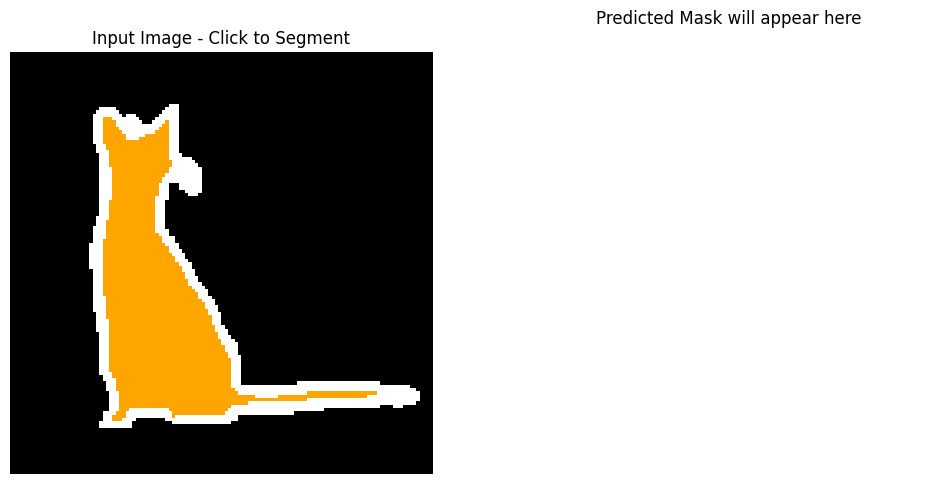

In [ ]:
# %% [code]
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import clip

# Make sure your model class is defined in your notebook.
# Here we assume CLIPSegmentationModelWithPointer is already defined from previous cells.

# --------- Load Model Weights and Set Up Model ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CLIP backbone & preprocessing (using ViT-L/14 as in your code).
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
clip_model.eval()
for param in clip_model.parameters():
    param.requires_grad = False

# Instantiate the pointer-based segmentation model.
# Adjust num_classes as needed. Here we assume a binary segmentation (foreground/background).
model = CLIPSegmentationModelWithPointer(clip_model=clip_model, num_classes=2).to(device)

# Set the path where your pointer model weights are saved.
model_path = "/content/drive/MyDrive/pointer_model_best.pth"  # <<< update this path if needed
state_dict = torch.load(model_path, map_location=device)

# Remove incompatible keys if necessary (e.g. keys from a model with different number of output classes).
for key in list(state_dict.keys()):
    if "seg_head.fuse_conv2" in key and state_dict[key].shape[0] != 2:
        del state_dict[key]
model.load_state_dict(state_dict, strict=False)
model.eval()
print("Model weights loaded and model is set to evaluation mode.")

# --------- Helper Functions for Pointer Heatmap and Inference ----------

def generate_pointer_heatmap(click_coord, H=224, W=224, sigma=5):
    """
    Generates a normalized 2D Gaussian pointer heatmap for an image of size H x W.

    Args:
      click_coord (tuple): (row, col) coordinate where the user clicked.
      H (int): Height of the target heatmap.
      W (int): Width of the target heatmap.
      sigma (float): Standard deviation of the Gaussian.

    Returns:
      np.array: Normalized heatmap with peak value 1.
    """
    y = np.arange(0, H)
    x = np.arange(0, W)
    xx, yy = np.meshgrid(x, y)
    heatmap = np.exp(-((xx - click_coord[1]) ** 2 + (yy - click_coord[0]) ** 2) / (2 * sigma ** 2))
    return heatmap / np.max(heatmap)

def on_click(event, img, ax_img, ax_mask):
    """
    Callback that is called when the user clicks on the input image.

    This function:
      - Gets the click coordinate.
      - Creates a pointer heatmap.
      - Preprocesses the image.
      - Runs inference with the pointer heatmap.
      - Displays the predicted mask and saves it to disk.
    """
    if event.inaxes != ax_img:
        return
    # Get click coordinates (x is horizontal; y is vertical)
    x, y = int(event.xdata), int(event.ydata)
    print(f"Clicked coordinate: ({y}, {x})")

    # Generate the pointer heatmap (image size is 224x224 after CLIP preprocessing)
    heatmap_np = generate_pointer_heatmap((y, x), H=224, W=224, sigma=5)
    pointer_heatmap = torch.from_numpy(heatmap_np).unsqueeze(0).unsqueeze(0).float().to(device)

    # Preprocess the image using CLIP's preprocess transform.
    processed_img = clip_preprocess(img).unsqueeze(0).to(device)

    # Run inference with the pointer-based segmentation model.
    with torch.no_grad():
        outputs = model(processed_img, pointer_heatmap)
        # Compute predicted mask by taking the argmax along the channel dimension.
        pred_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

    # Update the mask display axis.
    ax_mask.clear()
    ax_mask.imshow(pred_mask, cmap="gray")
    ax_mask.set_title("Predicted Mask")
    ax_mask.axis("off")
    plt.draw()

    # Save the predicted mask as an image file.
    # (If your model outputs labels 0 or 1, you can scale them to 0 or 255 for visibility.)
    mask_img = Image.fromarray((pred_mask * 255).astype(np.uint8))
    export_path = "predicted_mask.png"
    mask_img.save(export_path)
    print(f"Predicted mask exported to {export_path}")

# --------- Setup Interactive UX for Inference ----------

# Specify the path to an image you want to test.
# Update 'test_image.jpg' to point to your desired image file.
image_path = "/content/processed_3/Test/label/cat_Abyssinian_2.png"  # <<< update this path as needed
img = Image.open(image_path).convert("RGB")

# Create a figure with two subplots:
#   - Left: Display the input image (and register click events).
#   - Right: Will display the predicted mask after a click.
fig, (ax_img, ax_mask) = plt.subplots(1, 2, figsize=(12, 6))
ax_img.imshow(img)
ax_img.set_title("Input Image - Click to Segment")
ax_img.axis("off")
ax_mask.set_title("Predicted Mask will appear here")
ax_mask.axis("off")

# Connect the mouse-click event to the callback function.
cid = fig.canvas.mpl_connect('button_press_event', lambda event: on_click(event, img, ax_img, ax_mask))

print("Interactive inference UI is running. Click on the left image to generate a predicted mask.")
plt.show()

In [ ]:
!pip install --upgrade gradio

In [ ]:
# %% [code]
import torch
import numpy as np
from PIL import Image
import clip
import gradio as gr

# ---------------------------
# Model and Preprocessing Setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CLIP backbone and its preprocessing transform (using ViT-L/14)
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
clip_model.eval()
for param in clip_model.parameters():
    param.requires_grad = False

# Instantiate your pointer segmentation model.
# (Ensure CLIPSegmentationModelWithPointer is defined in a previous cell.)
# Here we use num_classes=2 (foreground vs. background) – adjust as needed.
model = CLIPSegmentationModelWithPointer(clip_model=clip_model, num_classes=2).to(device)

# Load the saved pointer model weights from Google Drive (update path if needed).
model_path = "/content/drive/MyDrive/pointer_model_best.pth"  # Update this path as necessary
state_dict = torch.load(model_path, map_location=device)
# Remove incompatible keys if necessary (e.g., from a model with a different number of output classes).
for key in list(state_dict.keys()):
    if "seg_head.fuse_conv2" in key and state_dict[key].shape[0] != 2:
        del state_dict[key]
model.load_state_dict(state_dict, strict=False)
model.eval()
print("Model weights loaded; model is in evaluation mode.")

# ---------------------------
# Helper Function for Pointer Heatmap
# ---------------------------
def generate_pointer_heatmap(click_coord, H=224, W=224, sigma=5):
    """
    Generates a normalized 2D Gaussian pointer heatmap for an image of size H x W.

    Args:
      click_coord (tuple): (row, col) coordinate where the user clicked.
      H (int): Height of the target heatmap.
      W (int): Width of the target heatmap.
      sigma (float): Standard deviation of the Gaussian.

    Returns:
      np.array: Normalized heatmap with peak value 1.
    """
    y = np.arange(H)
    x = np.arange(W)
    xx, yy = np.meshgrid(x, y)
    heatmap = np.exp(-((xx - click_coord[1])**2 + (yy - click_coord[0])**2) / (2 * sigma**2))
    return heatmap / np.max(heatmap)

# ---------------------------
# Inference Function for Gradio Interface
# ---------------------------
def inference_gradio_text(image, point_str):
    if not point_str:
        return "Please input coordinates (x,y) to specify a segmentation point."
    try:
        x_str, y_str = point_str.split(',')
        x, y = float(x_str.strip()), float(y_str.strip())
    except Exception as e:
        return f"Error parsing point coordinates: {e}"
    return inference_gradio(image, [[x, y]])

demo = gr.Interface(
    fn=inference_gradio_text,
    inputs=[
        gr.Image(type="pil", label="Upload an Image"),
        gr.Textbox(label="Enter click coordinates as x,y", placeholder="e.g., 100,150")
    ],
    outputs=gr.Image(type="pil", label="Predicted Mask"),
    title="Pointer-based Segmentation Inference (Textbox Version)",
    description="Upload an image and type in the coordinates (x,y) for segmentation."
)

demo.launch(debug=True)
# ---------------------------
# Create and Launch the Gradio Interface using Updated Components
# ---------------------------
# If you still get errors about Points, please run: !pip install --upgrade gradio
demo = gr.Interface(
    fn=inference_gradio,
    inputs=[
        gr.Image(type="pil", label="Upload an Image"),
        gr.components.Points(label="Click on the Image to Segment")
    ],
    outputs=gr.Image(type="pil", label="Predicted Mask"),
    title="Pointer-based Segmentation Inference",
    description="Upload an image and click on the object you wish to segment. The predicted binary segmentation mask is displayed."
)

demo.launch(debug=True)

Feature dimension: 768
Model weights loaded; model is in evaluation mode.
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://20e867ba8838357cd6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Received click coordinate (original): (200.0, 100.0)
Scaled click coordinate: (112, 37)
Received click coordinate (original): (500.0, 100.0)
Scaled click coordinate: (280, 37)
Received click coordinate (original): (500.0, 100.0)
Scaled click coordinate: (280, 37)
Received click coordinate (original): (200.0, 100.0)
Scaled click coordinate: (112, 37)
